# Setup

In [16]:
import nengo
import numpy as np

#import pytry
import scipy
#import nni

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from datetime import datetime
import sys,os

import optuna

In [17]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J




# Sim Parameters

In [34]:

#Sim parameters
sim_time = 60

#Model parameters
num_neurons = 100
sim_synapse = 0
model_neurons = nengo.LIF()

#Sys parameters
dt = 0.001

l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]
M = np.matrix([[0.1,0.1,0.1],[0,0.1,0.1],[0,0,0.1]])
x_mean = [0,0,0,0]
limits = [0.3,0.3,-1,1]
radius = np.sum(l)
#ks = 129.41716480250645
#lam = 0.8094360625273509

#ks = 87.43517605837582
#lam = 0.561370179388699
#ks = 240.43019522362528
#lam = 1.1027054080379453
#Reference traj
def ref_traj(t):
    return [0.1+0.1*np.cos((np.pi/5)*t), 0.1+0.1*np.sin((np.pi/5)*t), -np.pi*0.02*np.sin((np.pi/5)*t), np.pi*0.02*np.cos((np.pi/5)*t) ]
def ref_dd_traj(t): 
    return [(-np.pi**2/250)*np.cos(t*np.pi/5),(-np.pi**2/250)*np.sin(t*np.pi/5)]

## No Adaptive

In [124]:
def objective(trial):
    ks = trial.suggest_float("ks", 100, 300)
    lam = trial.suggest_float('lam',0.5,2)
    model, state_probe, reference_probe = create_model_no_adapt(ks,lam)
    with nengo.Simulator(model,dt = dt) as sim:
        sim.run(sim_time)
    ref_signal = sim.data[reference_probe]
    state_signal = -sim.data[state_probe]
    #return np.sqrt(np.mean((ref_signal-state_signal)**2))
    return np.sqrt(np.mean((ref_signal[int(10/dt):int(sim_time/dt)]-state_signal[int(10/dt):int(sim_time/dt)])**2))
study = optuna.create_study()
study.optimize(objective, n_trials=200)

study.best_params  






[I 2024-10-29 12:43:15,357] A new study created in memory with name: no-name-678b09d1-24ce-4a37-9238-3f06d86d3fbb


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:43:52,426] Trial 0 finished with value: 0.41374709767479106 and parameters: {'ks': 272.8686955119575, 'lam': 1.3871061373406537}. Best is trial 0 with value: 0.41374709767479106.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:44:29,408] Trial 1 finished with value: 0.0016882038037005778 and parameters: {'ks': 176.98546580768863, 'lam': 1.640752096414592}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:45:04,607] Trial 2 finished with value: 0.0025896213221297897 and parameters: {'ks': 104.166934517417, 'lam': 1.789922902108992}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:45:39,123] Trial 3 finished with value: 0.2950662045182771 and parameters: {'ks': 262.4872507244555, 'lam': 1.9099870870157722}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:46:13,689] Trial 4 finished with value: 2.9290980674819394e+21 and parameters: {'ks': 281.6122609372565, 'lam': 0.985160807344282}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:46:47,522] Trial 5 finished with value: 0.003062067083384346 and parameters: {'ks': 211.57832717229792, 'lam': 0.5702061032440268}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:47:21,988] Trial 6 finished with value: 0.0018875324863250095 and parameters: {'ks': 166.65627733770964, 'lam': 1.5316918697892925}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:47:56,654] Trial 7 finished with value: 0.23113567920222475 and parameters: {'ks': 260.7068392318695, 'lam': 1.7680778448751684}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:48:30,686] Trial 8 finished with value: 0.3784828846624469 and parameters: {'ks': 288.4245497516499, 'lam': 0.7214504934404822}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:49:04,586] Trial 9 finished with value: 0.4972869890469617 and parameters: {'ks': 284.521841444645, 'lam': 1.652762302858041}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:49:38,885] Trial 10 finished with value: 0.002137343469598622 and parameters: {'ks': 178.6559209328375, 'lam': 1.1987217571717186}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:50:12,889] Trial 11 finished with value: 0.0020822332165423775 and parameters: {'ks': 154.80957740063357, 'lam': 1.4768469263602424}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:50:49,315] Trial 12 finished with value: 0.0022885076254856437 and parameters: {'ks': 136.1633894672046, 'lam': 1.5264038637351312}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:51:25,283] Trial 13 finished with value: 0.0018318418103068087 and parameters: {'ks': 207.5323731950098, 'lam': 1.2192014867699303}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:52:01,786] Trial 14 finished with value: 0.0018462004188688889 and parameters: {'ks': 219.01380455940293, 'lam': 1.1280412743699846}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:52:36,899] Trial 15 finished with value: 0.0019783112379224534 and parameters: {'ks': 238.79894349889918, 'lam': 0.9188491542616601}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:53:13,314] Trial 16 finished with value: 0.0018597386514382149 and parameters: {'ks': 190.11950042352044, 'lam': 1.3316452810540174}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:53:49,497] Trial 17 finished with value: 0.0017756141259955623 and parameters: {'ks': 143.51030475522856, 'lam': 1.9692284016485186}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:54:26,513] Trial 18 finished with value: 0.0020104186636598887 and parameters: {'ks': 126.8169655626618, 'lam': 1.9506683085744971}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:55:03,429] Trial 19 finished with value: 0.00173596800722936 and parameters: {'ks': 146.15840737743235, 'lam': 1.9820591706762245}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:55:39,828] Trial 20 finished with value: 0.00253330468033372 and parameters: {'ks': 110.52309399449702, 'lam': 1.7171006505134234}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:56:14,968] Trial 21 finished with value: 0.0017229782247646789 and parameters: {'ks': 148.41425164257194, 'lam': 1.965270799368961}. Best is trial 1 with value: 0.0016882038037005778.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:56:50,760] Trial 22 finished with value: 0.0016523098553599526 and parameters: {'ks': 163.2707681262693, 'lam': 1.852160768494213}. Best is trial 22 with value: 0.0016523098553599526.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:57:26,176] Trial 23 finished with value: 0.0016179919830242783 and parameters: {'ks': 170.20473780841212, 'lam': 1.8106826662319315}. Best is trial 23 with value: 0.0016179919830242783.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:58:03,526] Trial 24 finished with value: 0.0017185571960041334 and parameters: {'ks': 175.357432119045, 'lam': 1.622259424629864}. Best is trial 23 with value: 0.0016179919830242783.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:58:39,008] Trial 25 finished with value: 0.0015074067495019707 and parameters: {'ks': 187.1946478839267, 'lam': 1.767737212059372}. Best is trial 25 with value: 0.0015074067495019707.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:59:15,158] Trial 26 finished with value: 0.0014393061147475457 and parameters: {'ks': 191.68850574600492, 'lam': 1.8200211612459438}. Best is trial 26 with value: 0.0014393061147475457.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 12:59:51,244] Trial 27 finished with value: 0.0011958511142903467 and parameters: {'ks': 231.80040022859026, 'lam': 1.8294521791867977}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:00:27,039] Trial 28 finished with value: 0.001497440181319664 and parameters: {'ks': 223.9793261648892, 'lam': 1.4401588166114763}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:01:02,392] Trial 29 finished with value: 0.0014748866531886936 and parameters: {'ks': 233.3856915536159, 'lam': 1.3968873163916606}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:01:38,571] Trial 30 finished with value: 0.0013210501488597275 and parameters: {'ks': 234.5866408216367, 'lam': 1.5950936597382404}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:02:14,187] Trial 31 finished with value: 0.0014883133242534416 and parameters: {'ks': 239.38567513994636, 'lam': 1.3521049133373122}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:02:50,037] Trial 32 finished with value: 0.001299345401446386 and parameters: {'ks': 239.16603814537172, 'lam': 1.6069872118720534}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:03:27,124] Trial 33 finished with value: 0.20234338295099313 and parameters: {'ks': 252.39852233167798, 'lam': 1.624693335961634}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:04:03,109] Trial 34 finished with value: 0.2214625829580573 and parameters: {'ks': 250.9903102206385, 'lam': 1.6935186051957003}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:04:38,952] Trial 35 finished with value: 0.0015467529841115288 and parameters: {'ks': 198.95416974112462, 'lam': 1.593336211056591}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:05:15,851] Trial 36 finished with value: 0.4095007699941066 and parameters: {'ks': 269.8773139771565, 'lam': 1.866810659047642}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:05:52,267] Trial 37 finished with value: 0.0015375727131864026 and parameters: {'ks': 205.33528349667975, 'lam': 1.546039380742696}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:06:28,283] Trial 38 finished with value: 0.0012589110104923005 and parameters: {'ks': 225.2737033035262, 'lam': 1.776109889178799}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:07:05,529] Trial 39 finished with value: 0.001285962842569528 and parameters: {'ks': 226.3953816569395, 'lam': 1.720130571825936}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:07:40,948] Trial 40 finished with value: 0.0013166430120803534 and parameters: {'ks': 219.4447016318179, 'lam': 1.7332608706021793}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:08:16,046] Trial 41 finished with value: 0.0013073129000355462 and parameters: {'ks': 222.55143652127578, 'lam': 1.7198507636780067}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:08:51,397] Trial 42 finished with value: 0.20626210642542012 and parameters: {'ks': 249.02720425995386, 'lam': 1.888733600674977}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:09:30,854] Trial 43 finished with value: 0.0012926321278562245 and parameters: {'ks': 228.87023629317807, 'lam': 1.687396517842165}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:10:12,178] Trial 44 finished with value: 0.3329319366959522 and parameters: {'ks': 262.90606485643633, 'lam': 1.666252777578732}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:10:50,550] Trial 45 finished with value: 0.0012296569289074605 and parameters: {'ks': 228.9151337716826, 'lam': 1.7941046748341671}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:11:27,094] Trial 46 finished with value: 0.0013182184793742902 and parameters: {'ks': 213.2090397958555, 'lam': 1.7902674057728454}. Best is trial 27 with value: 0.0011958511142903467.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:12:02,993] Trial 47 finished with value: 0.001178124155042274 and parameters: {'ks': 227.18320051563023, 'lam': 1.9073517964251332}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:12:39,192] Trial 48 finished with value: 0.32305143756311255 and parameters: {'ks': 295.943748919871, 'lam': 1.9002785307801922}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:13:15,694] Trial 49 finished with value: 0.0029978690052139025 and parameters: {'ks': 214.65351867052493, 'lam': 0.5769768833037594}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:13:51,658] Trial 50 finished with value: 0.0012948085601625847 and parameters: {'ks': 204.4985820816941, 'lam': 1.9211582578747275}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:14:27,224] Trial 51 finished with value: 0.0012108490757174477 and parameters: {'ks': 228.1236442103177, 'lam': 1.8357415738740006}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:15:03,122] Trial 52 finished with value: 0.0012202368847640686 and parameters: {'ks': 224.86434881108784, 'lam': 1.8492986399988038}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:15:40,006] Trial 53 finished with value: 0.16537723352835856 and parameters: {'ks': 245.32789782465395, 'lam': 1.8640595861970533}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:16:15,889] Trial 54 finished with value: 0.29725450651927826 and parameters: {'ks': 256.4659133652919, 'lam': 1.994316449834839}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:16:51,887] Trial 55 finished with value: 0.0012283565389330233 and parameters: {'ks': 230.97412607690833, 'lam': 1.7776774703589036}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:17:28,137] Trial 56 finished with value: 0.05478266298200048 and parameters: {'ks': 245.17665773602363, 'lam': 0.8985750325090924}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:18:03,403] Trial 57 finished with value: 0.0014033208062300343 and parameters: {'ks': 197.04946639364147, 'lam': 1.8179712410722775}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:18:39,402] Trial 58 finished with value: 0.0012512621696263492 and parameters: {'ks': 211.28684770152287, 'lam': 1.92837106872814}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:19:14,470] Trial 59 finished with value: 0.4939255929458474 and parameters: {'ks': 275.00580407385553, 'lam': 1.849890681752371}. Best is trial 47 with value: 0.001178124155042274.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:19:51,224] Trial 60 finished with value: 0.0011025307326896 and parameters: {'ks': 233.80178874520274, 'lam': 1.999596839526524}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:20:27,768] Trial 61 finished with value: 0.0011441393754492673 and parameters: {'ks': 230.711572924371, 'lam': 1.9414195525162867}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:21:04,153] Trial 62 finished with value: 0.0011302271269424135 and parameters: {'ks': 233.5924942452043, 'lam': 1.942320026857151}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:21:38,982] Trial 63 finished with value: 0.004466704459066252 and parameters: {'ks': 241.81310148542076, 'lam': 1.93870541648927}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:22:13,431] Trial 64 finished with value: 0.0011871491215167287 and parameters: {'ks': 216.4694751858749, 'lam': 1.9986666894302985}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:22:47,914] Trial 65 finished with value: 0.0011943360956727187 and parameters: {'ks': 217.39053644535306, 'lam': 1.9743615818603937}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:23:22,430] Trial 66 finished with value: 0.0012284762361731104 and parameters: {'ks': 210.63622388421086, 'lam': 1.9789981452077055}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:23:57,746] Trial 67 finished with value: 0.26207981469129193 and parameters: {'ks': 261.7467666432212, 'lam': 1.9165714763297605}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:24:32,296] Trial 68 finished with value: 0.0011958016971152852 and parameters: {'ks': 216.7597929517763, 'lam': 1.9780713542519115}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:25:06,728] Trial 69 finished with value: 0.0011680959712094296 and parameters: {'ks': 220.22451683407883, 'lam': 1.9980900958573535}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:25:41,328] Trial 70 finished with value: 0.0013179723442749785 and parameters: {'ks': 194.76292457366515, 'lam': 1.9894980957316253}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:26:15,927] Trial 71 finished with value: 0.0011818534266733556 and parameters: {'ks': 217.3805150748399, 'lam': 1.9997861406244137}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:26:50,543] Trial 72 finished with value: 0.0013014181000182293 and parameters: {'ks': 203.27512013496084, 'lam': 1.9226260532942168}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:27:25,526] Trial 73 finished with value: 0.0011140612381082006 and parameters: {'ks': 236.03046460583522, 'lam': 1.95346153999288}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:27:59,958] Trial 74 finished with value: 0.001144985315585459 and parameters: {'ks': 234.41466482373895, 'lam': 1.904120390700291}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:28:34,141] Trial 75 finished with value: 0.0011387435395688438 and parameters: {'ks': 236.42922040485874, 'lam': 1.8982817723177203}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:29:08,907] Trial 76 finished with value: 0.001150425518808026 and parameters: {'ks': 235.58967252214077, 'lam': 1.8821850674089777}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:29:43,040] Trial 77 finished with value: 0.0017645899574971122 and parameters: {'ks': 236.79008441682134, 'lam': 1.0855033986547287}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:30:17,572] Trial 78 finished with value: 0.007365961072475172 and parameters: {'ks': 243.37584352507116, 'lam': 1.8860792544819}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:30:52,238] Trial 79 finished with value: 0.3049810998659284 and parameters: {'ks': 256.12269162067497, 'lam': 1.9454699252401164}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:31:26,938] Trial 80 finished with value: 0.0011555295098889795 and parameters: {'ks': 235.17290209169977, 'lam': 1.875915257917462}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:32:01,804] Trial 81 finished with value: 0.0011562040045992846 and parameters: {'ks': 234.53958387439786, 'lam': 1.8804457291709982}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:32:36,436] Trial 82 finished with value: 0.0011537328051597618 and parameters: {'ks': 235.5973451433616, 'lam': 1.8756836402495494}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:33:11,069] Trial 83 finished with value: 0.2346195704679408 and parameters: {'ks': 267.54992838271414, 'lam': 1.7544142694795355}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:33:45,635] Trial 84 finished with value: 0.2586111048274372 and parameters: {'ks': 251.9514735672872, 'lam': 1.9469196960119066}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:34:20,501] Trial 85 finished with value: 0.0011850058404212775 and parameters: {'ks': 236.13079683100605, 'lam': 1.8104165110689006}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:34:54,817] Trial 86 finished with value: 0.22124352846389259 and parameters: {'ks': 247.75391850233032, 'lam': 1.8782913915031976}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:35:29,250] Trial 87 finished with value: 0.0015621772235703134 and parameters: {'ks': 239.2915661287675, 'lam': 1.2611424824096051}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:36:04,316] Trial 88 finished with value: 0.2665227233622256 and parameters: {'ks': 255.6067035163723, 'lam': 1.9433953706463736}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:36:38,532] Trial 89 finished with value: 0.0011962609538887167 and parameters: {'ks': 232.10667482366586, 'lam': 1.8258638638130815}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:37:13,348] Trial 90 finished with value: 0.0023395970977978155 and parameters: {'ks': 241.15455219990008, 'lam': 1.9087623521193995}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:37:48,280] Trial 91 finished with value: 0.0011515589878748598 and parameters: {'ks': 235.18316082736348, 'lam': 1.8836871689970784}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:38:22,896] Trial 92 finished with value: 0.23686202760763664 and parameters: {'ks': 248.40353554625705, 'lam': 1.75828335853263}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:38:57,312] Trial 93 finished with value: 0.001158608188065452 and parameters: {'ks': 234.92975453200907, 'lam': 1.8720706174956567}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:39:31,612] Trial 94 finished with value: 0.0012352820156530477 and parameters: {'ks': 222.3751903249882, 'lam': 1.845615225713684}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:40:06,428] Trial 95 finished with value: 0.0013372121082664027 and parameters: {'ks': 240.548576358978, 'lam': 1.954865217834835}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:40:41,227] Trial 96 finished with value: 0.1456937449486973 and parameters: {'ks': 244.4905321001363, 'lam': 1.9049079503632707}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:41:15,660] Trial 97 finished with value: 0.0012140362059685425 and parameters: {'ks': 231.38460733508128, 'lam': 1.7997056470669286}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:41:50,635] Trial 98 finished with value: 0.0012695992676288268 and parameters: {'ks': 226.78878419033123, 'lam': 1.7439463411668408}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:42:25,497] Trial 99 finished with value: 0.0012461557581382665 and parameters: {'ks': 237.47110649875876, 'lam': 1.690950501374257}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:43:00,500] Trial 100 finished with value: 0.33737087078891137 and parameters: {'ks': 259.1973932227661, 'lam': 1.854586934407194}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:43:34,831] Trial 101 finished with value: 0.0011535380469254528 and parameters: {'ks': 233.4614968774325, 'lam': 1.8958864373158066}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:44:09,451] Trial 102 finished with value: 0.0011691749829333372 and parameters: {'ks': 230.25883344118435, 'lam': 1.8952630532299488}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:44:44,542] Trial 103 finished with value: 0.0011877606443318164 and parameters: {'ks': 220.99606496520838, 'lam': 1.9501001676972345}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:45:19,716] Trial 104 finished with value: 0.1811186250889917 and parameters: {'ks': 246.50078349848434, 'lam': 1.9245167895164437}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:45:54,809] Trial 105 finished with value: 0.20015535883701585 and parameters: {'ks': 252.3063811655053, 'lam': 1.8314553991408042}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:46:29,421] Trial 106 finished with value: 0.00134962232860915 and parameters: {'ks': 207.80533954096256, 'lam': 1.792288433574679}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:47:04,171] Trial 107 finished with value: 0.0011632885480808678 and parameters: {'ks': 233.46232739328443, 'lam': 1.8765174121436288}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:47:39,364] Trial 108 finished with value: 0.0011718491548808063 and parameters: {'ks': 223.2273310342817, 'lam': 1.959350261088678}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:48:14,524] Trial 109 finished with value: 0.002109969634023943 and parameters: {'ks': 241.23395058877068, 'lam': 1.9099857547819483}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:48:49,354] Trial 110 finished with value: 0.0025969443187336245 and parameters: {'ks': 226.68622532154714, 'lam': 0.6642653376064268}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:49:23,738] Trial 111 finished with value: 0.0011550904871137377 and parameters: {'ks': 236.61415717229042, 'lam': 1.8639165065663559}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:49:58,652] Trial 112 finished with value: 0.08952889026372632 and parameters: {'ks': 243.83957736560018, 'lam': 1.851307547681446}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:50:33,075] Trial 113 finished with value: 0.0011078630305688677 and parameters: {'ks': 237.63678272854514, 'lam': 1.956131413934453}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:51:07,707] Trial 114 finished with value: 0.0011362764501487695 and parameters: {'ks': 230.27965529508322, 'lam': 1.9620117399092671}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:51:43,245] Trial 115 finished with value: 0.0011420515783713754 and parameters: {'ks': 229.14393101234725, 'lam': 1.9611872360846276}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:52:18,692] Trial 116 finished with value: 0.0011384990684638126 and parameters: {'ks': 228.92804460095445, 'lam': 1.9707696856974855}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:52:53,424] Trial 117 finished with value: 0.0011377367353628198 and parameters: {'ks': 229.53391552306977, 'lam': 1.9663378803786713}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:53:28,828] Trial 118 finished with value: 0.001160519184901431 and parameters: {'ks': 223.75186751769147, 'lam': 1.9772064931233093}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:54:03,861] Trial 119 finished with value: 0.001157584020914426 and parameters: {'ks': 226.37008039027862, 'lam': 1.9567267209633192}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:54:39,144] Trial 120 finished with value: 0.0012312520874787404 and parameters: {'ks': 214.32519619170796, 'lam': 1.9342519415834527}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:55:13,850] Trial 121 finished with value: 0.0011345814137402005 and parameters: {'ks': 230.13875889062982, 'lam': 1.9669655487196585}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:55:48,847] Trial 122 finished with value: 0.0011425006572369529 and parameters: {'ks': 228.21246066029866, 'lam': 1.969531665623557}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:56:23,902] Trial 123 finished with value: 0.0011291009996519197 and parameters: {'ks': 230.8434655791554, 'lam': 1.9715555398888152}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:56:59,011] Trial 124 finished with value: 0.001131372903507055 and parameters: {'ks': 230.26365548742928, 'lam': 1.9724950976986593}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:57:33,626] Trial 125 finished with value: 0.0011712219544543186 and parameters: {'ks': 219.5208057650578, 'lam': 1.999018080344106}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:58:09,492] Trial 126 finished with value: 0.0011409563557508962 and parameters: {'ks': 228.77365945967418, 'lam': 1.9671580868994614}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:58:44,709] Trial 127 finished with value: 0.001230033388668208 and parameters: {'ks': 211.31211304091548, 'lam': 1.96863948241473}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:59:19,678] Trial 128 finished with value: 0.001124124806483128 and parameters: {'ks': 229.39046833820734, 'lam': 1.9966924378027107}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 13:59:54,708] Trial 129 finished with value: 0.0022292605461830452 and parameters: {'ks': 114.55123855229479, 'lam': 1.9316358466109356}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:00:29,973] Trial 130 finished with value: 0.00116567865997878 and parameters: {'ks': 221.92415225296185, 'lam': 1.9853680145100072}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:01:04,644] Trial 131 finished with value: 0.0011432045789121475 and parameters: {'ks': 228.96244398492496, 'lam': 1.9605869478504336}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:01:39,783] Trial 132 finished with value: 0.0012733569810366668 and parameters: {'ks': 240.2566313920075, 'lam': 1.9293205521347367}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:02:14,616] Trial 133 finished with value: 0.0011202594169017724 and parameters: {'ks': 230.44075395786348, 'lam': 1.994467475203568}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:02:49,439] Trial 134 finished with value: 0.0011483498965543604 and parameters: {'ks': 224.12921715200412, 'lam': 1.9987341292958376}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:03:24,458] Trial 135 finished with value: 0.19923160869791964 and parameters: {'ks': 247.072602336117, 'lam': 1.92593629568147}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:03:59,338] Trial 136 finished with value: 0.0021044256277290663 and parameters: {'ks': 230.81374741368623, 'lam': 0.8808048234501225}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:04:34,375] Trial 137 finished with value: 0.0014091236423082049 and parameters: {'ks': 181.079625533428, 'lam': 1.9954166751755735}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:05:09,354] Trial 138 finished with value: 0.0011091210168165222 and parameters: {'ks': 238.4977033312999, 'lam': 1.962542078944367}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:05:44,441] Trial 139 finished with value: 0.0015529982914184316 and parameters: {'ks': 240.07805266163854, 'lam': 1.9236990997527945}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:06:19,637] Trial 140 finished with value: 0.15877346710805265 and parameters: {'ks': 243.46845550142578, 'lam': 1.9440541663877238}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:06:54,232] Trial 141 finished with value: 0.001128358338632805 and parameters: {'ks': 231.25675266789756, 'lam': 1.9690427797707901}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:07:29,256] Trial 142 finished with value: 0.001120166905348965 and parameters: {'ks': 238.89843699041373, 'lam': 1.9741670543045868}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:08:04,259] Trial 143 finished with value: 0.0011792678426345213 and parameters: {'ks': 217.93774870322352, 'lam': 1.9991713696014402}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:08:39,284] Trial 144 finished with value: 0.0011971849756354145 and parameters: {'ks': 239.34773163307247, 'lam': 1.9678394057944513}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:09:14,181] Trial 145 finished with value: 0.1783600767459569 and parameters: {'ks': 248.62939492836603, 'lam': 1.9129099617077627}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:09:48,876] Trial 146 finished with value: 0.0011346578113533934 and parameters: {'ks': 232.00068554045586, 'lam': 1.948505150381562}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:10:23,610] Trial 147 finished with value: 0.001139917874440276 and parameters: {'ks': 231.76914973604696, 'lam': 1.9398325684491913}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:10:58,875] Trial 148 finished with value: 0.0014600343202785598 and parameters: {'ks': 223.99669561969554, 'lam': 1.4868674274830465}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:11:33,785] Trial 149 finished with value: 0.010202980746817207 and parameters: {'ks': 243.0259069019936, 'lam': 1.9149774521638132}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:12:09,022] Trial 150 finished with value: 0.0011092123124982229 and parameters: {'ks': 237.9566878675468, 'lam': 1.9495229719739318}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:12:44,288] Trial 151 finished with value: 0.001117097349463268 and parameters: {'ks': 238.11430839263195, 'lam': 1.9476239679609715}. Best is trial 60 with value: 0.0011025307326896.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:13:19,024] Trial 152 finished with value: 0.001090024548279521 and parameters: {'ks': 237.82543294678618, 'lam': 1.9956446672813293}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:13:54,633] Trial 153 finished with value: 0.0011155595067008207 and parameters: {'ks': 237.9896857403133, 'lam': 1.9344032616980646}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:14:30,212] Trial 154 finished with value: 0.2816791749814272 and parameters: {'ks': 252.49604454415166, 'lam': 1.9985767841572613}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:15:05,301] Trial 155 finished with value: 0.0012684123055217169 and parameters: {'ks': 239.88969832239596, 'lam': 1.9009436136770872}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:15:40,145] Trial 156 finished with value: 0.0011198746550728368 and parameters: {'ks': 237.34317624382103, 'lam': 1.9300841479659314}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:16:15,380] Trial 157 finished with value: 0.0011199231321543193 and parameters: {'ks': 237.17834332450138, 'lam': 1.931000767017519}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:16:50,070] Trial 158 finished with value: 0.20415327758909713 and parameters: {'ks': 251.13688862132724, 'lam': 1.930300754378089}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:17:24,840] Trial 159 finished with value: 0.1745499977503234 and parameters: {'ks': 246.96616361097557, 'lam': 1.849139493056974}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:18:00,392] Trial 160 finished with value: 0.0011401877484467976 and parameters: {'ks': 236.5298785252756, 'lam': 1.8942348861936473}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:18:35,354] Trial 161 finished with value: 0.12365152890755877 and parameters: {'ks': 243.94306857850773, 'lam': 1.996801006328419}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:19:10,434] Trial 162 finished with value: 0.0011185962749394674 and parameters: {'ks': 236.9678266134824, 'lam': 1.9352388474574087}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:19:45,490] Trial 163 finished with value: 0.0011252823989429405 and parameters: {'ks': 236.73880365399913, 'lam': 1.9232047701876662}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:20:21,014] Trial 164 finished with value: 0.0011350430509939958 and parameters: {'ks': 238.56769796454233, 'lam': 1.9104547223698263}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:20:55,850] Trial 165 finished with value: 0.001113968464993875 and parameters: {'ks': 237.60284125852735, 'lam': 1.9408543546121806}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:21:30,621] Trial 166 finished with value: 0.0030696899744080256 and parameters: {'ks': 241.53352604184434, 'lam': 1.8675516678740587}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:22:04,642] Trial 167 finished with value: 0.0011160894917015345 and parameters: {'ks': 237.5637603772241, 'lam': 1.9346228832823407}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:22:44,576] Trial 168 finished with value: 0.2464977758934109 and parameters: {'ks': 255.1541274531237, 'lam': 1.932097246050138}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:23:21,633] Trial 169 finished with value: 0.17143826828721245 and parameters: {'ks': 245.05500648069562, 'lam': 1.8302572280609182}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:23:56,871] Trial 170 finished with value: 0.0011364164294047259 and parameters: {'ks': 237.7900155011804, 'lam': 1.8929719486645122}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:24:32,233] Trial 171 finished with value: 0.0011214509067071037 and parameters: {'ks': 236.85216780659488, 'lam': 1.9307515937656428}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:25:07,884] Trial 172 finished with value: 0.001122221107567107 and parameters: {'ks': 237.16362224867365, 'lam': 1.9279032946536032}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:25:42,648] Trial 173 finished with value: 0.21845244427254684 and parameters: {'ks': 248.56956384295415, 'lam': 1.9397682866404176}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:26:18,449] Trial 174 finished with value: 0.004484791980641746 and parameters: {'ks': 242.77876883198834, 'lam': 1.8917823635505961}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:26:53,396] Trial 175 finished with value: 0.0018705346605473177 and parameters: {'ks': 237.86277257148464, 'lam': 0.9972639912905155}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:27:28,939] Trial 176 finished with value: 0.0011274466350549837 and parameters: {'ks': 234.24847324373417, 'lam': 1.941819800538987}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:28:04,680] Trial 177 finished with value: 0.1245787478795051 and parameters: {'ks': 244.59501469760392, 'lam': 1.9972157380112663}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:28:39,775] Trial 178 finished with value: 0.001225206789605677 and parameters: {'ks': 239.87137760337313, 'lam': 1.8553734794452146}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:29:14,715] Trial 179 finished with value: 0.2017030074191638 and parameters: {'ks': 248.67279734947908, 'lam': 1.9077461041040493}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:29:50,008] Trial 180 finished with value: 0.0011209229881424792 and parameters: {'ks': 234.81253791839134, 'lam': 1.95014148932057}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:30:25,717] Trial 181 finished with value: 0.0011195091787653084 and parameters: {'ks': 235.0021928821142, 'lam': 1.9512699758311478}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:31:00,988] Trial 182 finished with value: 0.0011163367725515107 and parameters: {'ks': 235.53486245386847, 'lam': 1.9529717366628745}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:31:36,191] Trial 183 finished with value: 0.0028449587887192534 and parameters: {'ks': 241.6180769297853, 'lam': 1.9507090625280818}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:32:11,436] Trial 184 finished with value: 0.001155150171278383 and parameters: {'ks': 234.5022697222912, 'lam': 1.8828832835960019}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:32:46,475] Trial 185 finished with value: 0.0011195701546018006 and parameters: {'ks': 233.91086918270022, 'lam': 1.9616858947050315}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:33:21,516] Trial 186 finished with value: 0.08990552325561889 and parameters: {'ks': 243.16632984831713, 'lam': 1.9623825754609026}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:33:56,706] Trial 187 finished with value: 0.0011127510818039281 and parameters: {'ks': 234.77241838892266, 'lam': 1.9678855453588269}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:34:32,002] Trial 188 finished with value: 0.001141981640090262 and parameters: {'ks': 225.31762005837038, 'lam': 1.9999695876393486}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:35:06,628] Trial 189 finished with value: 0.0012090870300402123 and parameters: {'ks': 239.54796816199783, 'lam': 1.9714666248641635}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:35:42,434] Trial 190 finished with value: 0.001148001887311993 and parameters: {'ks': 233.8137951264905, 'lam': 1.9036937726461975}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:36:18,095] Trial 191 finished with value: 0.0011222892060864006 and parameters: {'ks': 234.8121638838203, 'lam': 1.9472502397404237}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:36:53,284] Trial 192 finished with value: 0.14372189691342194 and parameters: {'ks': 245.7628798287981, 'lam': 1.957473094848407}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:37:28,473] Trial 193 finished with value: 0.0015596872046504898 and parameters: {'ks': 233.569667712269, 'lam': 1.298938084932341}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:38:03,570] Trial 194 finished with value: 0.0016434119865605563 and parameters: {'ks': 239.7854765751091, 'lam': 1.1791090813389085}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:38:38,537] Trial 195 finished with value: 0.0011020022734714453 and parameters: {'ks': 237.81347557924227, 'lam': 1.971206392287694}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:39:13,704] Trial 196 finished with value: 0.12280152283380555 and parameters: {'ks': 242.77519171230063, 'lam': 1.976222770754399}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:39:48,813] Trial 197 finished with value: 0.2710846976374493 and parameters: {'ks': 250.94288333587636, 'lam': 1.928068553035789}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:40:24,423] Trial 198 finished with value: 0.0011659797283971405 and parameters: {'ks': 239.70809512523627, 'lam': 1.9090016280085769}. Best is trial 152 with value: 0.001090024548279521.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-10-29 14:41:00,094] Trial 199 finished with value: 0.0011535469785495622 and parameters: {'ks': 225.44319229571977, 'lam': 1.9744117492792554}. Best is trial 152 with value: 0.001090024548279521.


{'ks': 237.82543294678618, 'lam': 1.9956446672813293}

In [26]:
print(ks)

87.43517605837582


## Random Adaptive

In [46]:
def objective(trial):
    ks = trial.suggest_float("ks", 50, 250)
    lam = trial.suggest_float('lam',0.5,2)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3)
    model, state_probe, reference_probe = create_model_rand_adapt_2(ks,lam,learning_rate)
    with nengo.Simulator(model,dt = dt) as sim:
        sim.run(sim_time)
    ref_signal = sim.data[reference_probe]
    state_signal = -sim.data[state_probe]
    #return np.sqrt(np.mean((ref_signal-state_signal)**2))
    return np.sqrt(np.mean((ref_signal[int(10/dt):int(sim_time/dt)]-state_signal[int(10/dt):int(sim_time/dt)])**2))
study = optuna.create_study()
study.optimize(objective, n_trials=200)

study.best_params  






[I 2024-11-08 11:50:45,480] A new study created in memory with name: no-name-178073ac-7385-4e26-af9d-d81adbebca93


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:51:32,467] Trial 0 finished with value: 1.0348974356786345e+33 and parameters: {'ks': 202.62684598637117, 'lam': 1.3546747981835934, 'learning_rate': 0.00022695705746615075}. Best is trial 0 with value: 1.0348974356786345e+33.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:52:17,835] Trial 1 finished with value: 0.00038565177368669147 and parameters: {'ks': 167.23062120466025, 'lam': 0.7229596017531366, 'learning_rate': 0.0009134057294231541}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:53:03,494] Trial 2 finished with value: 0.00044328611951900915 and parameters: {'ks': 164.9386794646559, 'lam': 1.4920791459613152, 'learning_rate': 0.0008039375341704309}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:53:49,036] Trial 3 finished with value: 0.0003979494293779638 and parameters: {'ks': 173.5463702055323, 'lam': 1.718253019443173, 'learning_rate': 0.0002914437772397398}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:54:34,636] Trial 4 finished with value: 0.0009698101710051885 and parameters: {'ks': 64.83033071515977, 'lam': 1.4329499039206393, 'learning_rate': 0.00025038720534055427}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:55:21,803] Trial 5 finished with value: 0.0006121881559726224 and parameters: {'ks': 99.64029091397029, 'lam': 0.5231906096507416, 'learning_rate': 0.000516636540149068}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:56:11,490] Trial 6 finished with value: 0.0006731444306504526 and parameters: {'ks': 125.5018080426379, 'lam': 1.3986547850968922, 'learning_rate': 0.00019661724273031144}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:56:57,379] Trial 7 finished with value: 0.2338882186399457 and parameters: {'ks': 222.7305528493357, 'lam': 1.035916803046806, 'learning_rate': 1.6717674186173947e-06}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:57:43,712] Trial 8 finished with value: 1.1552968619115943e+151 and parameters: {'ks': 210.39082132075512, 'lam': 1.8066617692290818, 'learning_rate': 0.0008433985318745821}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:58:30,905] Trial 9 finished with value: 0.0008831215769870407 and parameters: {'ks': 63.1682855259786, 'lam': 1.2951192008816015, 'learning_rate': 0.00037297627397907474}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 11:59:16,171] Trial 10 finished with value: 0.00039627416643113646 and parameters: {'ks': 129.96190209723974, 'lam': 0.7518246629229032, 'learning_rate': 0.0009524344162592298}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:00:02,976] Trial 11 finished with value: 0.00039797188706211474 and parameters: {'ks': 130.72246972776674, 'lam': 0.7299650930729044, 'learning_rate': 0.0009899392700330524}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:00:49,175] Trial 12 finished with value: 0.00041910440437513906 and parameters: {'ks': 174.56094900188103, 'lam': 0.9610625627346207, 'learning_rate': 0.0006665239973821981}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:01:35,142] Trial 13 finished with value: 0.00046265355436952776 and parameters: {'ks': 105.90148257557541, 'lam': 0.7937625030203004, 'learning_rate': 0.0009921735545589591}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:02:21,846] Trial 14 finished with value: 0.0004560575911602907 and parameters: {'ks': 145.58154770142235, 'lam': 0.5757545299175675, 'learning_rate': 0.00076692319684205}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:03:07,979] Trial 15 finished with value: 0.0006718619749958467 and parameters: {'ks': 191.5484503789421, 'lam': 1.0095923161319682, 'learning_rate': 0.0006169851433227274}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

C:\Users\graem\AppData\Local\Temp\ipykernel_2964\246138370.py:11: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((ref_signal[int(10/dt):int(sim_time/dt)]-state_signal[int(10/dt):int(sim_time/dt)])**2))
[I 2024-11-08 12:03:53,915] Trial 16 finished with value: inf and parameters: {'ks': 247.8988484200064, 'lam': 0.8056013273732214, 'learning_rate': 0.0008902449705462112}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:04:40,276] Trial 17 finished with value: 0.0004812688760578857 and parameters: {'ks': 103.598454766515, 'lam': 0.6703716278115582, 'learning_rate': 0.0007185856731918014}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:05:26,677] Trial 18 finished with value: 0.00043712565537350586 and parameters: {'ks': 152.78596178738368, 'lam': 1.1372259430230103, 'learning_rate': 0.000913849768871517}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:06:13,357] Trial 19 finished with value: 0.0005915152553088845 and parameters: {'ks': 130.19087055371293, 'lam': 1.9825222709692203, 'learning_rate': 0.0005379704521209325}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:06:59,469] Trial 20 finished with value: 0.000999172502836879 and parameters: {'ks': 78.0897738157307, 'lam': 0.5117706406639575, 'learning_rate': 0.00039880140169014117}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:07:45,844] Trial 21 finished with value: 0.0007240342583278008 and parameters: {'ks': 177.68667404803796, 'lam': 1.6269664495550216, 'learning_rate': 8.684889520650093e-05}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:08:31,474] Trial 22 finished with value: 0.00038980904247981006 and parameters: {'ks': 155.70997817004073, 'lam': 1.6546886142777515, 'learning_rate': 0.0003978506318639925}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:09:17,957] Trial 23 finished with value: 0.00047182623562983607 and parameters: {'ks': 150.50232080105988, 'lam': 0.8994377801785907, 'learning_rate': 0.00042929068507685444}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:10:04,237] Trial 24 finished with value: 0.0004180551211685959 and parameters: {'ks': 118.4579800065311, 'lam': 1.0893707268226915, 'learning_rate': 0.0006422519611002557}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:10:50,914] Trial 25 finished with value: 0.0006023457840302369 and parameters: {'ks': 145.9991906310363, 'lam': 1.2399745299711549, 'learning_rate': 0.0009045638080948713}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:11:37,834] Trial 26 finished with value: 0.00045867757287653066 and parameters: {'ks': 187.85920169702325, 'lam': 1.5509123862024212, 'learning_rate': 0.0005759430135925272}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:12:24,784] Trial 27 finished with value: 0.00038859599748284235 and parameters: {'ks': 160.90582902388206, 'lam': 1.1922877400686116, 'learning_rate': 0.0004586765852698363}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:13:11,080] Trial 28 finished with value: 0.0005426420781163544 and parameters: {'ks': 165.9257618390605, 'lam': 1.9031470328658777, 'learning_rate': 0.00044543814071926386}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:13:57,779] Trial 29 finished with value: 1.846565026939479e+88 and parameters: {'ks': 219.99183072038238, 'lam': 1.1857602269926995, 'learning_rate': 0.0003307251321016532}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:14:44,698] Trial 30 finished with value: 0.0005193747359694033 and parameters: {'ks': 193.70665994099218, 'lam': 1.6712615946387106, 'learning_rate': 0.00019891450683759562}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:15:31,921] Trial 31 finished with value: 0.0004680076241089879 and parameters: {'ks': 137.56244848780503, 'lam': 0.883359566337147, 'learning_rate': 0.0004813431481781989}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:16:18,738] Trial 32 finished with value: 0.0004216286135911394 and parameters: {'ks': 159.24955684129245, 'lam': 0.64836497554506, 'learning_rate': 0.00076436783965783}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:17:05,636] Trial 33 finished with value: 0.0005855157540042853 and parameters: {'ks': 117.98434199160077, 'lam': 1.3511862601583668, 'learning_rate': 0.00032983415536124686}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:17:53,119] Trial 34 finished with value: 0.0004532907469857099 and parameters: {'ks': 164.71618082274125, 'lam': 1.5276862952415984, 'learning_rate': 0.0005758777872002346}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:18:40,829] Trial 35 finished with value: 0.0014641529387669624 and parameters: {'ks': 181.05440750019216, 'lam': 1.761763069649251, 'learning_rate': 0.0007001093379506113}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:19:27,959] Trial 36 finished with value: 0.0005252513384050141 and parameters: {'ks': 87.70448123891387, 'lam': 0.8152451171304664, 'learning_rate': 0.0008542453030807228}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:20:14,752] Trial 37 finished with value: 0.0004373753989128781 and parameters: {'ks': 139.05411298742686, 'lam': 0.7014744203164425, 'learning_rate': 0.000951084253950231}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:21:01,735] Trial 38 finished with value: 0.0010527091934812046 and parameters: {'ks': 204.4258602630348, 'lam': 0.6085635082555493, 'learning_rate': 0.00027080617313694376}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:21:48,423] Trial 39 finished with value: 0.0005969523519426317 and parameters: {'ks': 158.82370459867576, 'lam': 1.4414543305575218, 'learning_rate': 0.0008048859901208566}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:22:35,643] Trial 40 finished with value: 0.0010310878391453348 and parameters: {'ks': 118.47598248003968, 'lam': 0.9234166169864961, 'learning_rate': 0.00012371331626436063}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:23:22,533] Trial 41 finished with value: 0.0005700223950181728 and parameters: {'ks': 170.40171467899958, 'lam': 1.7358258631387868, 'learning_rate': 0.00028239475973564353}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:24:09,821] Trial 42 finished with value: 0.0006888749382516952 and parameters: {'ks': 183.33036687680527, 'lam': 1.8317623753171133, 'learning_rate': 0.0004807789891904311}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:24:57,343] Trial 43 finished with value: 0.0004982043094189977 and parameters: {'ks': 158.06920327278485, 'lam': 1.6130961312630006, 'learning_rate': 0.00035507111710030405}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:25:44,904] Trial 44 finished with value: 0.0005826494470196509 and parameters: {'ks': 142.41461005325522, 'lam': 1.308156170746938, 'learning_rate': 0.00028928041739719135}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:26:32,378] Trial 45 finished with value: 0.00045583343521412727 and parameters: {'ks': 173.91986618932023, 'lam': 1.4697455333931249, 'learning_rate': 0.00023673475900330893}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:27:20,294] Trial 46 finished with value: 0.0006326996014398081 and parameters: {'ks': 127.7883106932626, 'lam': 0.9888381072898551, 'learning_rate': 0.0004060240074494527}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:28:07,689] Trial 47 finished with value: 0.0010139831095437274 and parameters: {'ks': 199.32656778325446, 'lam': 1.8729780774528375, 'learning_rate': 0.00016111879663300855}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:28:55,207] Trial 48 finished with value: 0.000430473151249041 and parameters: {'ks': 136.6330850732215, 'lam': 1.0809267124657362, 'learning_rate': 0.0005346784276639446}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:29:43,534] Trial 49 finished with value: 0.00044377839220017943 and parameters: {'ks': 152.88578375707104, 'lam': 0.7366491892948851, 'learning_rate': 0.0009453643412529541}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:30:32,109] Trial 50 finished with value: 0.0007306502383045286 and parameters: {'ks': 54.71990222134657, 'lam': 1.990909262720422, 'learning_rate': 0.0008529661002776908}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:31:19,374] Trial 51 finished with value: 0.0003870101687339822 and parameters: {'ks': 131.60572009593213, 'lam': 0.5754577532462827, 'learning_rate': 0.000974219785489389}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:32:07,999] Trial 52 finished with value: 0.00046319380386851443 and parameters: {'ks': 111.47631626184591, 'lam': 0.5655178964977912, 'learning_rate': 0.0009955672751780483}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:32:55,083] Trial 53 finished with value: 0.0004647983728051116 and parameters: {'ks': 97.26696519243296, 'lam': 0.7666176459034247, 'learning_rate': 0.0009400573651024702}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:33:43,422] Trial 54 finished with value: 0.00046430592790015556 and parameters: {'ks': 166.83070156954955, 'lam': 0.846481906275145, 'learning_rate': 0.0008072521651105002}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:34:31,079] Trial 55 finished with value: 0.000460024370164493 and parameters: {'ks': 148.9175825213466, 'lam': 0.5087102730191408, 'learning_rate': 0.0004370455011161856}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:35:17,792] Trial 56 finished with value: 0.00043470538243137516 and parameters: {'ks': 125.34335288885984, 'lam': 0.6250907750674103, 'learning_rate': 0.0008973655876656665}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:36:06,107] Trial 57 finished with value: 0.0003857610143599814 and parameters: {'ks': 157.23918254136723, 'lam': 0.5698447962314884, 'learning_rate': 0.0009652610509065081}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:36:54,466] Trial 58 finished with value: 0.00042337763445303943 and parameters: {'ks': 157.5405030469478, 'lam': 0.5892267031296747, 'learning_rate': 0.0009632891846892056}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:37:42,316] Trial 59 finished with value: 0.0004354659256981413 and parameters: {'ks': 145.76724777171515, 'lam': 0.5488753870924208, 'learning_rate': 0.000872351629265381}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:38:31,842] Trial 60 finished with value: 0.00043017441252238877 and parameters: {'ks': 135.43147776083836, 'lam': 0.6712276632037553, 'learning_rate': 0.0009147309191735581}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:39:20,466] Trial 61 finished with value: 0.00042754906225872866 and parameters: {'ks': 177.80763174332307, 'lam': 0.7268839065664915, 'learning_rate': 0.0009670002982564578}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:40:09,050] Trial 62 finished with value: 1.9468675203091604e+146 and parameters: {'ks': 186.45751078302445, 'lam': 1.651648238502423, 'learning_rate': 0.0009953404328132036}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:40:57,826] Trial 63 finished with value: 0.00040125706446617217 and parameters: {'ks': 170.628468631575, 'lam': 1.7154594600188362, 'learning_rate': 0.00037229642284177845}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:41:45,282] Trial 64 finished with value: 0.00048732959721536326 and parameters: {'ks': 154.83321728057766, 'lam': 1.2091660712299959, 'learning_rate': 0.0007579330872173958}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:42:33,445] Trial 65 finished with value: 0.0004654739651910689 and parameters: {'ks': 164.31845597461347, 'lam': 1.379716515513425, 'learning_rate': 0.00032732813628609975}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:43:21,577] Trial 66 finished with value: 0.000430649668072373 and parameters: {'ks': 122.25050674733447, 'lam': 0.6719384562448822, 'learning_rate': 0.0008234529847901276}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:44:10,319] Trial 67 finished with value: 0.0006781026267336491 and parameters: {'ks': 134.286556816743, 'lam': 1.5793496186014564, 'learning_rate': 0.0009200922243141667}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:44:58,576] Trial 68 finished with value: 0.0013068778917638916 and parameters: {'ks': 112.3924202147899, 'lam': 1.9282978283400642, 'learning_rate': 3.2449680461453284e-05}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:45:47,733] Trial 69 finished with value: 0.0004530402111942116 and parameters: {'ks': 194.2676254479114, 'lam': 0.5004681642256856, 'learning_rate': 0.0004891530066175485}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:46:35,944] Trial 70 finished with value: inf and parameters: {'ks': 243.06251144680778, 'lam': 0.8554982231729331, 'learning_rate': 0.0008838889639309249}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:47:24,844] Trial 71 finished with value: 0.00040328349317451565 and parameters: {'ks': 145.24272865533231, 'lam': 0.7904806485894328, 'learning_rate': 0.0009779787855467672}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:48:14,117] Trial 72 finished with value: 0.0003917988306965834 and parameters: {'ks': 162.14170223212793, 'lam': 0.6278546598405437, 'learning_rate': 0.0009356866368764526}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:49:02,313] Trial 73 finished with value: 0.0004396872642360252 and parameters: {'ks': 162.13213442194976, 'lam': 0.6125559194335984, 'learning_rate': 0.0004614385869463402}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:49:52,261] Trial 74 finished with value: 0.0004200781344386026 and parameters: {'ks': 171.46259093566044, 'lam': 0.553322009470798, 'learning_rate': 0.0009258941574066004}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:50:41,560] Trial 75 finished with value: 0.00043394568702741763 and parameters: {'ks': 177.53098167950034, 'lam': 0.6399984914791532, 'learning_rate': 0.00040290532772099314}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:51:30,033] Trial 76 finished with value: 0.00042734166420262506 and parameters: {'ks': 142.12371388958945, 'lam': 0.6965143473854898, 'learning_rate': 0.0008614252079570094}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:52:19,704] Trial 77 finished with value: 0.000433234880929686 and parameters: {'ks': 131.44559476137152, 'lam': 0.7413043555928767, 'learning_rate': 0.0005827468756282744}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:53:09,761] Trial 78 finished with value: 0.0004285924245838609 and parameters: {'ks': 147.8960306407932, 'lam': 0.9384533220513851, 'learning_rate': 0.000833184883183848}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:54:00,562] Trial 79 finished with value: 0.00043551187962710463 and parameters: {'ks': 153.7371372986637, 'lam': 1.1420195303251102, 'learning_rate': 0.000515976368759082}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:54:50,790] Trial 80 finished with value: 0.0007567614153982403 and parameters: {'ks': 168.29914856693867, 'lam': 1.5031888342649822, 'learning_rate': 0.0009559567450681782}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:55:41,595] Trial 81 finished with value: 0.0008310999904876824 and parameters: {'ks': 161.26755758354318, 'lam': 1.7883733736859728, 'learning_rate': 0.0008942156302550651}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:56:31,600] Trial 82 finished with value: 0.0004332743106515905 and parameters: {'ks': 130.0641878042833, 'lam': 0.6969083234406779, 'learning_rate': 0.000997440859341963}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:57:21,891] Trial 83 finished with value: 0.0004393848324888562 and parameters: {'ks': 141.62723153891713, 'lam': 0.7691659482642988, 'learning_rate': 0.0009371567869454629}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:58:12,223] Trial 84 finished with value: 0.0007016077702659718 and parameters: {'ks': 151.1669349031631, 'lam': 0.5928020547211964, 'learning_rate': 0.00020609383893204348}. Best is trial 1 with value: 0.00038565177368669147.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:59:03,126] Trial 85 finished with value: 0.00037012478126928505 and parameters: {'ks': 182.03928078558954, 'lam': 0.5455361569664974, 'learning_rate': 0.0009792907286244135}. Best is trial 85 with value: 0.00037012478126928505.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 12:59:53,044] Trial 86 finished with value: 0.00043114328409224174 and parameters: {'ks': 182.828677033291, 'lam': 0.6382878668454427, 'learning_rate': 0.0009749046980290928}. Best is trial 85 with value: 0.00037012478126928505.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:00:42,559] Trial 87 finished with value: 0.00036621671977522173 and parameters: {'ks': 189.19857559182762, 'lam': 0.5625320464533535, 'learning_rate': 0.0009350669792573978}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:01:33,461] Trial 88 finished with value: inf and parameters: {'ks': 214.0035779872712, 'lam': 0.5487424092713553, 'learning_rate': 0.000910858400251746}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:02:24,514] Trial 89 finished with value: 0.00041766797108538006 and parameters: {'ks': 199.78594781168255, 'lam': 0.5300039742185748, 'learning_rate': 0.0008775528678654885}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:03:15,260] Trial 90 finished with value: 0.0005438239776150769 and parameters: {'ks': 190.52922223334122, 'lam': 0.5807934020238441, 'learning_rate': 0.0009430423355419984}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:04:05,317] Trial 91 finished with value: 0.00039265256112503533 and parameters: {'ks': 175.8807406072974, 'lam': 0.6173784351331715, 'learning_rate': 0.0009640612561989146}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:04:55,595] Trial 92 finished with value: 0.00039335444296804663 and parameters: {'ks': 177.43888532930822, 'lam': 0.6649778508594243, 'learning_rate': 0.0009702184905889962}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:05:47,446] Trial 93 finished with value: 0.0004516821349171608 and parameters: {'ks': 176.49232735787697, 'lam': 0.6565975819898368, 'learning_rate': 0.000978093498022191}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:06:38,276] Trial 94 finished with value: 0.00036678193609620017 and parameters: {'ks': 185.0089581705251, 'lam': 0.6219107632445925, 'learning_rate': 0.0009632860399041501}. Best is trial 87 with value: 0.00036621671977522173.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:07:29,282] Trial 95 finished with value: 0.00035621299386955513 and parameters: {'ks': 185.89497456978876, 'lam': 0.6167448867885978, 'learning_rate': 0.0009266022086314243}. Best is trial 95 with value: 0.00035621299386955513.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:08:20,372] Trial 96 finished with value: 0.000604523246842177 and parameters: {'ks': 207.32828259947405, 'lam': 0.5367899199371028, 'learning_rate': 0.0007896308248405083}. Best is trial 95 with value: 0.00035621299386955513.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:09:13,135] Trial 97 finished with value: 0.0003721893202824013 and parameters: {'ks': 196.6540743876778, 'lam': 0.5704093973306782, 'learning_rate': 0.0009334498152219251}. Best is trial 95 with value: 0.00035621299386955513.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:10:03,348] Trial 98 finished with value: 0.0003906061449289768 and parameters: {'ks': 195.31761992623152, 'lam': 0.5022351398642884, 'learning_rate': 0.000895545246492851}. Best is trial 95 with value: 0.00035621299386955513.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:10:55,114] Trial 99 finished with value: 0.0003610706665653074 and parameters: {'ks': 185.9009836159109, 'lam': 0.5918243610395169, 'learning_rate': 0.0009223997007160922}. Best is trial 95 with value: 0.00035621299386955513.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:11:47,127] Trial 100 finished with value: 0.0003740437462998127 and parameters: {'ks': 187.59851005357686, 'lam': 0.57278771886774, 'learning_rate': 0.0008484053125066297}. Best is trial 95 with value: 0.00035621299386955513.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:12:38,775] Trial 101 finished with value: 0.00035243588439339175 and parameters: {'ks': 187.8021621970442, 'lam': 0.5738399267155245, 'learning_rate': 0.0008477314971366498}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:13:29,693] Trial 102 finished with value: 0.00042320449588191533 and parameters: {'ks': 186.57819799151, 'lam': 0.5777448447466363, 'learning_rate': 0.0008548185802236709}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:14:21,638] Trial 103 finished with value: 0.0003932343590944568 and parameters: {'ks': 190.2155976954453, 'lam': 0.5872938014763276, 'learning_rate': 0.0009174205596720782}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:15:13,826] Trial 104 finished with value: 0.0004157567131126281 and parameters: {'ks': 199.69363166144683, 'lam': 0.7007869496754489, 'learning_rate': 0.0007317737085124625}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:16:06,596] Trial 105 finished with value: 0.00046585530250354786 and parameters: {'ks': 182.86348051162577, 'lam': 0.5348615733023256, 'learning_rate': 0.0008332351118313558}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:16:58,684] Trial 106 finished with value: 0.0007534164641727498 and parameters: {'ks': 210.38440637989072, 'lam': 0.5637803587951985, 'learning_rate': 0.0008742432902295411}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:17:48,415] Trial 107 finished with value: 0.0004050391665872409 and parameters: {'ks': 196.78697556199208, 'lam': 0.5266786524276827, 'learning_rate': 0.0009030007523303348}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:18:36,604] Trial 108 finished with value: 0.00041749553964635753 and parameters: {'ks': 185.99553068167373, 'lam': 0.6021588072026102, 'learning_rate': 0.0009513660331123515}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:19:24,424] Trial 109 finished with value: 0.0010039850089078749 and parameters: {'ks': 180.81399892395902, 'lam': 0.6847055507226334, 'learning_rate': 0.0009325957954285944}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:20:11,606] Trial 110 finished with value: 0.0006206970352023439 and parameters: {'ks': 191.71852106662644, 'lam': 0.6363860037013346, 'learning_rate': 0.0007849725466980313}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:20:58,523] Trial 111 finished with value: 0.0004965658368534614 and parameters: {'ks': 188.11005946699242, 'lam': 0.7210936150828288, 'learning_rate': 0.0009851949987905988}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:21:45,240] Trial 112 finished with value: 0.0005149463847585604 and parameters: {'ks': 203.5561415203917, 'lam': 0.6083654762032836, 'learning_rate': 0.0009176473176209428}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:22:32,917] Trial 113 finished with value: 0.000363877653149614 and parameters: {'ks': 172.61340779963012, 'lam': 0.5627620544644231, 'learning_rate': 0.0008710107691672517}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:23:22,289] Trial 114 finished with value: 0.00037511858149849277 and parameters: {'ks': 170.81321575839087, 'lam': 0.5650209813305067, 'learning_rate': 0.0008192104872365903}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:24:10,838] Trial 115 finished with value: 0.0003710157258412542 and parameters: {'ks': 171.98463249261215, 'lam': 0.56326055771388, 'learning_rate': 0.0008269391204255258}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:24:59,206] Trial 116 finished with value: 0.00043015534315099584 and parameters: {'ks': 173.73801188843953, 'lam': 0.5023410684899638, 'learning_rate': 0.0008213714350911119}. Best is trial 101 with value: 0.00035243588439339175.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:25:47,487] Trial 117 finished with value: 0.00034416684459877067 and parameters: {'ks': 181.65447145445222, 'lam': 0.5519833989150125, 'learning_rate': 0.0008470064472452936}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:26:35,505] Trial 118 finished with value: 0.00039380689749811675 and parameters: {'ks': 180.59688834639346, 'lam': 0.5520430026833736, 'learning_rate': 0.000844921008672498}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:27:23,222] Trial 119 finished with value: 0.0004204309598538018 and parameters: {'ks': 196.55055844770678, 'lam': 0.6585117099419663, 'learning_rate': 0.000792547728752522}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:28:12,068] Trial 120 finished with value: 0.00043245954518982737 and parameters: {'ks': 184.69686652958134, 'lam': 0.5318834163259929, 'learning_rate': 0.0006990105217771254}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:29:00,053] Trial 121 finished with value: 0.0003734651874811097 and parameters: {'ks': 168.7681612727568, 'lam': 0.6025827430475382, 'learning_rate': 0.0008652315482997482}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:29:48,430] Trial 122 finished with value: 0.00036882471721555633 and parameters: {'ks': 169.39710352788936, 'lam': 0.6065546077187545, 'learning_rate': 0.000815519189612567}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:30:38,099] Trial 123 finished with value: 0.0004024042764970558 and parameters: {'ks': 190.22508286214958, 'lam': 0.6045826048221439, 'learning_rate': 0.0008625512851655568}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:31:26,815] Trial 124 finished with value: 0.00041094246388621267 and parameters: {'ks': 181.2541429115362, 'lam': 0.6376531808525707, 'learning_rate': 0.0008804484591893699}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:32:14,755] Trial 125 finished with value: 0.00038652121261660815 and parameters: {'ks': 192.98843313058933, 'lam': 0.5888628237064012, 'learning_rate': 0.0007660490926185571}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:33:03,546] Trial 126 finished with value: 0.00038523575589708846 and parameters: {'ks': 166.70167006632684, 'lam': 0.617623530856505, 'learning_rate': 0.0008486826346719009}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:33:54,451] Trial 127 finished with value: 0.00037103154808908835 and parameters: {'ks': 173.08676294367157, 'lam': 0.6704652417587544, 'learning_rate': 0.0007352680876668103}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:34:43,354] Trial 128 finished with value: 0.0003709988176397947 and parameters: {'ks': 173.1490623042223, 'lam': 0.675696234496474, 'learning_rate': 0.0007276033621155781}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:35:32,708] Trial 129 finished with value: 0.0003922522893443825 and parameters: {'ks': 173.92831207773358, 'lam': 0.6700834166904854, 'learning_rate': 0.0007516478755904619}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:36:21,313] Trial 130 finished with value: 0.0004133607896167473 and parameters: {'ks': 179.6094380697225, 'lam': 0.705325482963426, 'learning_rate': 0.000653073998743848}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:37:10,561] Trial 131 finished with value: 0.0003892086964015437 and parameters: {'ks': 168.69255581848725, 'lam': 0.5234600077901188, 'learning_rate': 0.0007146347620204314}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:38:00,528] Trial 132 finished with value: 0.0004472614201971946 and parameters: {'ks': 173.23769080807193, 'lam': 0.6437518840318345, 'learning_rate': 0.0008093869807568055}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:38:49,455] Trial 133 finished with value: 0.0003744937348298238 and parameters: {'ks': 166.5632087789, 'lam': 0.5502767822656216, 'learning_rate': 0.0008970405054615083}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:39:40,056] Trial 134 finished with value: 0.0003813274379273423 and parameters: {'ks': 184.6355164405936, 'lam': 0.7564963323510623, 'learning_rate': 0.0006842618370633352}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:40:29,400] Trial 135 finished with value: 0.0004205585098092466 and parameters: {'ks': 175.0221413320176, 'lam': 0.6182011261866133, 'learning_rate': 0.0007835825243149401}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:41:17,474] Trial 136 finished with value: 0.000418136731236079 and parameters: {'ks': 164.27240893082435, 'lam': 0.5025332968744683, 'learning_rate': 0.0006180312740789113}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:42:07,117] Trial 137 finished with value: 0.0003880844066147603 and parameters: {'ks': 170.34094806417508, 'lam': 0.6667951452690772, 'learning_rate': 0.0007475282899345229}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:42:56,021] Trial 138 finished with value: 0.00048495057081729854 and parameters: {'ks': 200.36945900307393, 'lam': 0.5926776476276625, 'learning_rate': 0.00087676155552116}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:43:44,299] Trial 139 finished with value: 0.0004287306592785763 and parameters: {'ks': 179.10958908286165, 'lam': 0.7253697254580858, 'learning_rate': 0.0009230679060990107}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:44:33,753] Trial 140 finished with value: 0.0008232570187745005 and parameters: {'ks': 205.49534481068278, 'lam': 0.5517758207431906, 'learning_rate': 0.0008261577582553464}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:45:22,712] Trial 141 finished with value: 0.00034647339745067104 and parameters: {'ks': 188.19206412186242, 'lam': 0.5601332487728085, 'learning_rate': 0.0008436408222449214}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:46:10,494] Trial 142 finished with value: 0.0005268189356931091 and parameters: {'ks': 188.5429686413381, 'lam': 0.6273308871865201, 'learning_rate': 0.0008912979219676976}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:46:59,858] Trial 143 finished with value: 0.0004131132580625758 and parameters: {'ks': 184.66104115481966, 'lam': 0.5793455558094768, 'learning_rate': 0.0008635437015457602}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:47:48,668] Trial 144 finished with value: 0.0004892010577816769 and parameters: {'ks': 194.0744717178738, 'lam': 0.5282236755133087, 'learning_rate': 0.0007979036087043117}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:48:38,123] Trial 145 finished with value: 0.0004139345006493383 and parameters: {'ks': 179.6913035973063, 'lam': 0.6040452789411193, 'learning_rate': 0.0008355648536837213}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:49:27,334] Trial 146 finished with value: 0.0004431031980678793 and parameters: {'ks': 183.30506880890857, 'lam': 0.6486903606650419, 'learning_rate': 0.0009377706863255802}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:50:16,559] Trial 147 finished with value: 0.00037925251888607734 and parameters: {'ks': 175.8093153271617, 'lam': 0.5543224800515351, 'learning_rate': 0.0009114792720930672}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:51:05,445] Trial 148 finished with value: 0.0005801998413001978 and parameters: {'ks': 196.97982788076476, 'lam': 0.6761760936354143, 'learning_rate': 0.0009541195015024581}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:51:54,503] Trial 149 finished with value: 0.00048804454117471776 and parameters: {'ks': 192.5612688425561, 'lam': 0.5797416433261986, 'learning_rate': 0.000999850552606596}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:52:43,645] Trial 150 finished with value: 0.00038335028652299627 and parameters: {'ks': 171.54380312676517, 'lam': 0.5254060049302143, 'learning_rate': 0.000880344730417958}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:53:32,912] Trial 151 finished with value: 0.0004595179530308889 and parameters: {'ks': 187.99061742219405, 'lam': 0.5691198065494556, 'learning_rate': 0.0008382432590701434}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:54:22,426] Trial 152 finished with value: 0.0003851625574535229 and parameters: {'ks': 188.00953215812143, 'lam': 0.6059484861991854, 'learning_rate': 0.0008551564204884296}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:55:12,356] Trial 153 finished with value: 0.0003762281736424858 and parameters: {'ks': 177.9535592318777, 'lam': 0.5002722228697545, 'learning_rate': 0.0007783430088630218}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:56:01,712] Trial 154 finished with value: 0.0004105893822651376 and parameters: {'ks': 182.1215455007988, 'lam': 0.5612771859708885, 'learning_rate': 0.0008029404322777486}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:56:50,370] Trial 155 finished with value: 0.00043900745499972767 and parameters: {'ks': 191.1267356742641, 'lam': 0.63085985005905, 'learning_rate': 0.0008606484699539247}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:57:39,944] Trial 156 finished with value: 0.0003825103767325634 and parameters: {'ks': 185.58136204080333, 'lam': 0.5864168354444591, 'learning_rate': 0.0009033872632107372}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:58:29,701] Trial 157 finished with value: 0.000431130452389755 and parameters: {'ks': 173.55430516661528, 'lam': 0.6839292808476958, 'learning_rate': 0.0008189794185709005}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 13:59:19,211] Trial 158 finished with value: 0.00043800514598214347 and parameters: {'ks': 201.0118841894403, 'lam': 0.5403310826600997, 'learning_rate': 0.0007320647363391687}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:00:09,801] Trial 159 finished with value: 0.0003850734152200683 and parameters: {'ks': 162.6943445340359, 'lam': 0.6180878355609462, 'learning_rate': 0.0009309724779685503}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:00:59,388] Trial 160 finished with value: 0.0003849933667491638 and parameters: {'ks': 167.81062562147437, 'lam': 0.5755054550142074, 'learning_rate': 0.0008424536059582679}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:01:49,547] Trial 161 finished with value: 0.00036782011439022227 and parameters: {'ks': 168.1254280201699, 'lam': 0.5505190691483135, 'learning_rate': 0.0008939646806399108}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:02:39,688] Trial 162 finished with value: 0.00036294886424881117 and parameters: {'ks': 177.97193017629291, 'lam': 0.5391445740032316, 'learning_rate': 0.000881028507623223}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:03:29,732] Trial 163 finished with value: 0.00042604199053934954 and parameters: {'ks': 158.85650327402047, 'lam': 0.5311770590256825, 'learning_rate': 0.0008843924479559236}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:04:17,678] Trial 164 finished with value: 0.0004974331914995777 and parameters: {'ks': 178.720015876796, 'lam': 0.6541406746581396, 'learning_rate': 0.0009491744529961088}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:05:07,938] Trial 165 finished with value: 0.0003718482215994674 and parameters: {'ks': 170.83487208477496, 'lam': 0.5998388260820672, 'learning_rate': 0.0009111535946355113}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:05:57,038] Trial 166 finished with value: 0.00042717827926026775 and parameters: {'ks': 175.33057950555641, 'lam': 0.5444115137143785, 'learning_rate': 0.0009064387863802176}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:06:46,382] Trial 167 finished with value: 0.0004396080960958953 and parameters: {'ks': 182.2005599002362, 'lam': 0.6387366440763462, 'learning_rate': 0.0009311218713804042}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:07:35,258] Trial 168 finished with value: 0.00037049640271380365 and parameters: {'ks': 171.4936032334087, 'lam': 0.5227815794978031, 'learning_rate': 0.0009623985022142591}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:08:25,013] Trial 169 finished with value: 0.000381794758389293 and parameters: {'ks': 173.7042257810189, 'lam': 0.5007079600035081, 'learning_rate': 0.0009560170284141479}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:09:13,751] Trial 170 finished with value: 0.00038806859830679136 and parameters: {'ks': 169.79365904328222, 'lam': 0.5350051968177875, 'learning_rate': 0.0009813139869857893}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:10:05,353] Trial 171 finished with value: 0.00040755828275351735 and parameters: {'ks': 165.54056866237983, 'lam': 0.5650375893411068, 'learning_rate': 0.0009224249501277109}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:10:54,639] Trial 172 finished with value: 0.00038517509040331035 and parameters: {'ks': 178.02169428650836, 'lam': 0.5907871606504138, 'learning_rate': 0.0008914570466513955}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:11:44,796] Trial 173 finished with value: 0.0004306740193452671 and parameters: {'ks': 183.72193794835562, 'lam': 0.6076774527760054, 'learning_rate': 0.0009727094229370261}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:12:35,478] Trial 174 finished with value: 0.00037852202889519 and parameters: {'ks': 172.33924153883265, 'lam': 0.5576070710648129, 'learning_rate': 0.0009449600358386574}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:13:24,636] Trial 175 finished with value: 0.0004000465659368783 and parameters: {'ks': 195.97475998789724, 'lam': 0.522299183890781, 'learning_rate': 0.0009074153668509653}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:14:14,195] Trial 176 finished with value: 0.00042526711723586057 and parameters: {'ks': 190.22753138728422, 'lam': 0.6238264208092607, 'learning_rate': 0.0008843519073349839}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:15:03,625] Trial 177 finished with value: 0.0003872609678108273 and parameters: {'ks': 162.24825190128743, 'lam': 0.5844672949644887, 'learning_rate': 0.0009294922248510086}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:15:53,522] Trial 178 finished with value: 0.0003876219935391106 and parameters: {'ks': 180.4887674561706, 'lam': 0.5512518055725, 'learning_rate': 0.0009623224086892814}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:16:41,692] Trial 179 finished with value: 0.00037344214252503646 and parameters: {'ks': 176.17938336481944, 'lam': 0.6498295902195704, 'learning_rate': 0.0008681704231868719}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:17:32,322] Trial 180 finished with value: 0.000353398511667785 and parameters: {'ks': 185.49994726794284, 'lam': 0.5195958811739017, 'learning_rate': 0.0009058886320545352}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:18:24,272] Trial 181 finished with value: 0.0004339892106101846 and parameters: {'ks': 184.23160971054367, 'lam': 0.5003907561203861, 'learning_rate': 0.0009040233906476131}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:19:14,338] Trial 182 finished with value: 0.0003871438137944574 and parameters: {'ks': 186.8289954679357, 'lam': 0.5323801775645122, 'learning_rate': 0.0009181439522273388}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:20:05,962] Trial 183 finished with value: 0.000394095297436658 and parameters: {'ks': 192.34913207810897, 'lam': 0.5926016506370297, 'learning_rate': 0.0009444304585348697}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:20:55,885] Trial 184 finished with value: 0.00040164959142701003 and parameters: {'ks': 170.6533413150937, 'lam': 0.5604417961978079, 'learning_rate': 0.000870810910979245}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:21:47,068] Trial 185 finished with value: 0.00036824436799604026 and parameters: {'ks': 178.98239141692326, 'lam': 0.5249258837260448, 'learning_rate': 0.0008295535974676997}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:22:38,708] Trial 186 finished with value: 0.00038849419042169303 and parameters: {'ks': 178.16075302358774, 'lam': 0.5224516824863413, 'learning_rate': 0.0008196382544572147}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:23:29,126] Trial 187 finished with value: 0.0004297878278512224 and parameters: {'ks': 166.15670868035275, 'lam': 0.6108151833796005, 'learning_rate': 0.0008365114455448226}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:24:20,705] Trial 188 finished with value: 0.000375391966765573 and parameters: {'ks': 181.42523959163483, 'lam': 0.5006354135875917, 'learning_rate': 0.000802919919342629}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:25:11,189] Trial 189 finished with value: 0.00035437899116160817 and parameters: {'ks': 175.42262407202534, 'lam': 0.5479977921068477, 'learning_rate': 0.0008461514605756249}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:26:01,345] Trial 190 finished with value: 0.00040642586431463107 and parameters: {'ks': 186.93995618688675, 'lam': 0.5465986579073917, 'learning_rate': 0.000853190753281604}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:26:52,455] Trial 191 finished with value: 0.00041330203192309616 and parameters: {'ks': 174.90510287112994, 'lam': 0.5760347990554859, 'learning_rate': 0.0008872281820653402}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:27:44,236] Trial 192 finished with value: 0.0004296546051943593 and parameters: {'ks': 170.52196906166785, 'lam': 0.5296747980385618, 'learning_rate': 0.000826506054505742}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:28:35,867] Trial 193 finished with value: 0.00039268974681759496 and parameters: {'ks': 180.53653190558722, 'lam': 0.59627212249001, 'learning_rate': 0.0008452195766569067}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:29:27,940] Trial 194 finished with value: 0.00038857313202266875 and parameters: {'ks': 175.73272709165553, 'lam': 0.5560026534215234, 'learning_rate': 0.0008680211994066373}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:30:19,018] Trial 195 finished with value: 0.0003955466821614267 and parameters: {'ks': 167.7318847812872, 'lam': 0.6174947837982429, 'learning_rate': 0.0008103990321855422}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:31:09,781] Trial 196 finished with value: 0.00037370050795615796 and parameters: {'ks': 182.9182050142893, 'lam': 0.5284045789427262, 'learning_rate': 0.000768203952609962}. Best is trial 117 with value: 0.00034416684459877067.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:32:00,524] Trial 197 finished with value: 0.00034400245748633814 and parameters: {'ks': 172.92698399221555, 'lam': 0.5706395245491774, 'learning_rate': 0.0008935049630213426}. Best is trial 197 with value: 0.00034400245748633814.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:32:51,581] Trial 198 finished with value: 0.0006128080837243244 and parameters: {'ks': 69.03913444786396, 'lam': 1.2793229445579777, 'learning_rate': 0.0008935324473085256}. Best is trial 197 with value: 0.00034400245748633814.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:33:41,606] Trial 199 finished with value: 0.000509692549402289 and parameters: {'ks': 177.50332695272587, 'lam': 1.043929793248143, 'learning_rate': 0.0008520575260791419}. Best is trial 197 with value: 0.00034400245748633814.


{'ks': 172.92698399221555,
 'lam': 0.5706395245491774,
 'learning_rate': 0.0008935049630213426}

## Selected Adaptive

In [47]:
def objective(trial):
    ks = trial.suggest_float("ks", 50, 250)
    lam = trial.suggest_float('lam',0.5,2)
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1e-5)
    rho_specified = trial.suggest_float('rho_specified',0,1)
    gain = trial.suggest_float('gain',50,250)
    model, state_probe, reference_probe = create_model_proj_adapt_2(ks,lam,learning_rate,rho_specified,gain)
    with nengo.Simulator(model,dt = dt) as sim:
        sim.run(sim_time)
    ref_signal = sim.data[reference_probe]
    state_signal = -sim.data[state_probe]
    #return np.sqrt(np.mean((ref_signal-state_signal)**2))
    return np.sqrt(np.mean((ref_signal[int(10/dt):int(sim_time/dt)]-state_signal[int(10/dt):int(sim_time/dt)])**2))

study = optuna.create_study()
study.optimize(objective, n_trials=200)

study.best_params  






[I 2024-11-08 14:33:41,626] A new study created in memory with name: no-name-1c121fdd-6903-40ed-8438-70e344618003


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:34:30,409] Trial 0 finished with value: 0.0020885569779817916 and parameters: {'ks': 129.77201365393375, 'lam': 1.181322925273204, 'learning_rate': 4.917980493771329e-06, 'rho_specified': 0.4118938185024176, 'gain': 116.10375125720027}. Best is trial 0 with value: 0.0020885569779817916.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:36:58,961] Trial 3 finished with value: 0.0025167419884517634 and parameters: {'ks': 166.5520548509023, 'lam': 0.584070916985204, 'learning_rate': 3.7496812077292094e-06, 'rho_specified': 0.7146316870612434, 'gain': 96.1812828565306}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:37:47,222] Trial 4 finished with value: 0.0018051547199455216 and parameters: {'ks': 201.8987264722439, 'lam': 1.0310586662289698, 'learning_rate': 2.0004571073578135e-06, 'rho_specified': 0.4865353108186069, 'gain': 211.3656046602505}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:38:33,236] Trial 5 finished with value: 0.0016430610774924082 and parameters: {'ks': 165.93396341912546, 'lam': 1.6049799860427985, 'learning_rate': 1.8457012403852416e-07, 'rho_specified': 0.7639873226357257, 'gain': 93.09316260961131}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:39:18,897] Trial 6 finished with value: 0.0017446222392257936 and parameters: {'ks': 129.0046056816355, 'lam': 1.8578888918751753, 'learning_rate': 7.894525769011439e-07, 'rho_specified': 0.3207792366694038, 'gain': 181.2178963657076}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:40:04,626] Trial 7 finished with value: 0.0017410100297284563 and parameters: {'ks': 155.8948526951208, 'lam': 1.4445834272575049, 'learning_rate': 1.9881507386227917e-06, 'rho_specified': 0.7876971370120045, 'gain': 55.195617925602505}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:40:49,906] Trial 8 finished with value: 0.00435444603508004 and parameters: {'ks': 50.06106170728515, 'lam': 1.6723582530189924, 'learning_rate': 1.618223194973682e-06, 'rho_specified': 0.6272536860770914, 'gain': 111.49187489266876}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 14:41:35,315] Trial 9 finished with value: 0.0016183164798290314 and parameters: {'ks': 176.78175977242825, 'lam': 1.1849529685970053, 'learning_rate': 4.219842940262715e-06, 'rho_specified': 0.14459398766545362, 'gain': 119.53997112779955}. Best is trial 2 with value: 0.0010947419408087464.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

[I 2024-11-08 16:36:24,769] Trial 157 finished with value: 0.0007672766241252391 and parameters: {'ks': 197.8175980990768, 'lam': 1.960749694429313, 'learning_rate': 9.996371117915443e-06, 'rho_specified': 0.46360033486396934, 'gain': 193.6024922368476}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:37:19,373] Trial 158 finished with value: 0.0009702079490384091 and parameters: {'ks': 198.81065955541186, 'lam': 1.9321719538222086, 'learning_rate': 6.316155888521147e-06, 'rho_specified': 0.4737551438214937, 'gain': 196.2706452844432}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:38:12,024] Trial 159 finished with value: 0.030016402125034824 and parameters: {'ks': 211.5672226466355, 'lam': 1.9564941590136904, 'learning_rate': 9.999594973839048e-06, 'rho_specified': 0.4269728013252981, 'gain': 183.37204467820214}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:39:04,551] Trial 160 finished with value: 0.0008217034902560947 and parameters: {'ks': 187.2691693966218, 'lam': 1.8868190853931868, 'learning_rate': 9.825882902941676e-06, 'rho_specified': 0.4645364199357633, 'gain': 193.40520384546616}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:39:57,306] Trial 161 finished with value: 0.0007806484350932271 and parameters: {'ks': 195.47694803499178, 'lam': 1.965812453677654, 'learning_rate': 9.615981926295804e-06, 'rho_specified': 0.443738327337699, 'gain': 198.30311851381362}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:40:50,249] Trial 162 finished with value: 0.0032217218608738525 and parameters: {'ks': 204.0533579852614, 'lam': 1.963247992930803, 'learning_rate': 3.449338922798081e-06, 'rho_specified': 0.4901654077899348, 'gain': 196.93285210440078}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:41:43,270] Trial 163 finished with value: 0.0007917393778578836 and parameters: {'ks': 197.84257308582838, 'lam': 1.9993607561441065, 'learning_rate': 9.788044307130153e-06, 'rho_specified': 0.3674992506137848, 'gain': 186.67139844879972}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:42:36,027] Trial 164 finished with value: 0.0008208201709587883 and parameters: {'ks': 190.39137694204732, 'lam': 1.920738577556135, 'learning_rate': 9.273859198557246e-06, 'rho_specified': 0.4386031550561058, 'gain': 191.61674122512323}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:43:28,516] Trial 165 finished with value: 0.001077173323819169 and parameters: {'ks': 181.50115803880448, 'lam': 1.9470591617625173, 'learning_rate': 4.7237777481126085e-06, 'rho_specified': 0.401027415422947, 'gain': 199.73717201115343}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:44:21,120] Trial 166 finished with value: 0.0007749726480299657 and parameters: {'ks': 195.54410747606235, 'lam': 1.9719003721154365, 'learning_rate': 9.6271043136883e-06, 'rho_specified': 0.4527172008690561, 'gain': 207.9465628122163}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:45:14,673] Trial 167 finished with value: 0.0008336187243791908 and parameters: {'ks': 200.15089203966187, 'lam': 1.9129312101555884, 'learning_rate': 9.825077291821884e-06, 'rho_specified': 0.4896631769955223, 'gain': 211.8911142571594}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:46:08,306] Trial 168 finished with value: 0.0007821785550787127 and parameters: {'ks': 187.09636365302202, 'lam': 1.999887893802637, 'learning_rate': 9.995679847041749e-06, 'rho_specified': 0.4673725165306814, 'gain': 207.72236005869365}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:47:01,460] Trial 169 finished with value: 0.00702499803923531 and parameters: {'ks': 208.13203856176304, 'lam': 1.5034946667828955, 'learning_rate': 9.402949700404978e-06, 'rho_specified': 0.4211750927555316, 'gain': 203.3984412632852}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:47:54,142] Trial 170 finished with value: 0.0014450314994641144 and parameters: {'ks': 202.8228409005465, 'lam': 0.6896942394312084, 'learning_rate': 9.016341036991248e-06, 'rho_specified': 0.5422234853666308, 'gain': 193.54134114331433}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:48:47,196] Trial 171 finished with value: 0.0007766824693938475 and parameters: {'ks': 195.23757769678318, 'lam': 1.966762968219182, 'learning_rate': 9.636771873509294e-06, 'rho_specified': 0.44776796147591474, 'gain': 196.35660020596646}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:49:39,935] Trial 172 finished with value: 0.000781208815748802 and parameters: {'ks': 195.85863170587484, 'lam': 1.968012832762913, 'learning_rate': 9.614926573645457e-06, 'rho_specified': 0.45759237910124556, 'gain': 189.2142153138846}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:50:33,340] Trial 173 finished with value: 0.0007866744155184714 and parameters: {'ks': 192.63484111159826, 'lam': 1.9388514903474399, 'learning_rate': 9.782385141910027e-06, 'rho_specified': 0.4805501644776611, 'gain': 197.93358098700998}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:51:26,335] Trial 174 finished with value: 0.000787177276258756 and parameters: {'ks': 198.96472751751452, 'lam': 1.9720117237543724, 'learning_rate': 9.994998064811996e-06, 'rho_specified': 0.4103515984435836, 'gain': 194.7861416380259}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:52:19,854] Trial 175 finished with value: 0.0008135770900464311 and parameters: {'ks': 184.91756066275147, 'lam': 1.9985255511115334, 'learning_rate': 9.417424754818469e-06, 'rho_specified': 0.5018787347920693, 'gain': 201.64386120685904}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:53:12,404] Trial 176 finished with value: 0.0008025062382322773 and parameters: {'ks': 190.8476659511654, 'lam': 1.9171611946518028, 'learning_rate': 9.652252427363034e-06, 'rho_specified': 0.4467065537935037, 'gain': 210.3079002819866}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:54:06,488] Trial 177 finished with value: 0.0016107223711103477 and parameters: {'ks': 204.02153468873414, 'lam': 1.9450445425460527, 'learning_rate': 9.10624142014612e-06, 'rho_specified': 0.42469279462832055, 'gain': 205.87576849020172}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:55:00,476] Trial 178 finished with value: 0.0007980052002741543 and parameters: {'ks': 195.3003572122819, 'lam': 1.8795364921059823, 'learning_rate': 9.800782085424965e-06, 'rho_specified': 0.5256059803458536, 'gain': 186.29597023240595}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:55:54,133] Trial 179 finished with value: 0.0008221143592252966 and parameters: {'ks': 199.28447836016278, 'lam': 1.9731301147424656, 'learning_rate': 9.512571365393293e-06, 'rho_specified': 0.37898175839477743, 'gain': 190.85862373328308}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:56:47,875] Trial 180 finished with value: 0.0008060128903988518 and parameters: {'ks': 188.69857136255106, 'lam': 1.999841092439231, 'learning_rate': 9.23004953904631e-06, 'rho_specified': 0.48069776523835805, 'gain': 195.9922353581795}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:57:41,716] Trial 181 finished with value: 0.0007803319659597664 and parameters: {'ks': 194.24157645848277, 'lam': 1.9573874508492695, 'learning_rate': 9.662696794933335e-06, 'rho_specified': 0.4412388212399366, 'gain': 200.9584136207495}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:58:34,633] Trial 182 finished with value: 0.0007870632240683832 and parameters: {'ks': 195.84729276710638, 'lam': 1.9442793082748, 'learning_rate': 9.693357257839115e-06, 'rho_specified': 0.46464995973758183, 'gain': 202.63108600231305}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 16:59:26,204] Trial 183 finished with value: 0.000781059134459778 and parameters: {'ks': 191.60557325338584, 'lam': 1.96655071046468, 'learning_rate': 9.840594010409873e-06, 'rho_specified': 0.43006542244182655, 'gain': 199.4892883719868}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:00:17,767] Trial 184 finished with value: 0.0010087938461499984 and parameters: {'ks': 201.25634801867142, 'lam': 1.909473660836014, 'learning_rate': 9.987841857102963e-06, 'rho_specified': 0.45360643084657676, 'gain': 192.85426392925214}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:01:08,891] Trial 185 finished with value: 0.0008174165792506536 and parameters: {'ks': 186.18205129036897, 'lam': 1.9721592881516312, 'learning_rate': 9.453764355011555e-06, 'rho_specified': 0.5053423420277919, 'gain': 181.88960310794698}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:01:59,792] Trial 186 finished with value: 0.0020751236725304314 and parameters: {'ks': 204.93341916622416, 'lam': 1.9285083095851592, 'learning_rate': 9.618722109809688e-06, 'rho_specified': 0.40576033815135537, 'gain': 208.7993250853455}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:02:51,360] Trial 187 finished with value: 0.0007980798602202154 and parameters: {'ks': 193.8376538843804, 'lam': 1.9461789497281823, 'learning_rate': 9.370720272838987e-06, 'rho_specified': 0.4399966547880493, 'gain': 204.02450659699386}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:03:42,610] Trial 188 finished with value: 0.0007719825686289554 and parameters: {'ks': 198.37475494706268, 'lam': 1.9999563135413996, 'learning_rate': 9.800621985672545e-06, 'rho_specified': 0.636142026700218, 'gain': 196.54409092964067}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:04:33,659] Trial 189 finished with value: 0.000767405696452977 and parameters: {'ks': 198.50432358758897, 'lam': 1.977828955030392, 'learning_rate': 9.992453782592091e-06, 'rho_specified': 0.6413929648957531, 'gain': 196.18501088173218}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:05:25,176] Trial 190 finished with value: 0.0007915843556521619 and parameters: {'ks': 198.67829159828295, 'lam': 1.8970239535703775, 'learning_rate': 9.810261305335985e-06, 'rho_specified': 0.6300855923840116, 'gain': 185.40969849830307}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:06:16,693] Trial 191 finished with value: 0.005879055262966481 and parameters: {'ks': 207.3300500669402, 'lam': 1.978487403717841, 'learning_rate': 9.999468855845224e-06, 'rho_specified': 0.637137748444634, 'gain': 196.56785198662868}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:07:08,120] Trial 192 finished with value: 0.001012490212400289 and parameters: {'ks': 201.2380883195556, 'lam': 1.995805904311271, 'learning_rate': 9.838145024290048e-06, 'rho_specified': 0.6544681283556324, 'gain': 191.53461138126133}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:07:59,345] Trial 193 finished with value: 0.0007787080200936712 and parameters: {'ks': 196.34021006923197, 'lam': 1.9983338415651946, 'learning_rate': 9.54908931447189e-06, 'rho_specified': 0.5962803527104221, 'gain': 188.91004001047116}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:08:50,761] Trial 194 finished with value: 0.0012579339325377876 and parameters: {'ks': 118.79667804876352, 'lam': 1.9723010434448938, 'learning_rate': 9.514527524883162e-06, 'rho_specified': 0.620258916665613, 'gain': 176.89487252127202}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:09:39,414] Trial 195 finished with value: 0.0009650322485071773 and parameters: {'ks': 196.4044689584587, 'lam': 1.935400234437871, 'learning_rate': 5.752113030967214e-06, 'rho_specified': 0.5983231722770852, 'gain': 189.08794242330964}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:10:27,641] Trial 196 finished with value: 0.020466366219668387 and parameters: {'ks': 211.15932033577525, 'lam': 1.9619506919790024, 'learning_rate': 9.305332439524893e-06, 'rho_specified': 0.5714784440336419, 'gain': 193.7304744588991}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:11:17,362] Trial 197 finished with value: 0.0013992513507394113 and parameters: {'ks': 203.18891016397325, 'lam': 1.997570175252477, 'learning_rate': 9.635864003885694e-06, 'rho_specified': 0.582010051365808, 'gain': 187.90336784039596}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:12:09,203] Trial 198 finished with value: 0.0007976586969024541 and parameters: {'ks': 197.51403091029226, 'lam': 1.9208091369613172, 'learning_rate': 9.494656557823866e-06, 'rho_specified': 0.6439038460661374, 'gain': 181.67104872962338}. Best is trial 108 with value: 0.0007575596474451302.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:13:01,297] Trial 199 finished with value: 0.0007725727185313156 and parameters: {'ks': 192.7430644462198, 'lam': 1.999892836414552, 'learning_rate': 9.732855293720892e-06, 'rho_specified': 0.6160898902388954, 'gain': 200.5532797814957}. Best is trial 108 with value: 0.0007575596474451302.


{'ks': 196.11618763796173,
 'lam': 1.997902049591582,
 'learning_rate': 9.963797644587236e-06,
 'rho_specified': 0.5904934874971519,
 'gain': 225.43220259102085}

## SSP Adaptive

In [48]:
def objective(trial):
    ks = trial.suggest_float("ks", 50, 250)
    lam = trial.suggest_float('lam',0.5,2)
    learning_rate = trial.suggest_float("learning_rate", 1e-8, 1e-5)
    model, state_probe, reference_probe = create_model_SSP_adapt_3(ks,lam,learning_rate)
    with nengo.Simulator(model,dt = dt) as sim:
        sim.run(sim_time)
    ref_signal = sim.data[reference_probe]
    state_signal = -sim.data[state_probe]
    #return np.sqrt(np.mean((ref_signal-state_signal)**2))
    return np.sqrt(np.mean((ref_signal[int(10/dt):int(sim_time/dt)]-state_signal[int(10/dt):int(sim_time/dt)])**2))
#encoders_type = 'random'
encoders_type = 'place-cells'
#psd_sampling = 'gaussian'
psd_sampling = 'uniform'
domain_ranges_ = np.array([[-0.3,0.3],[-1.,1.],[-0.3,0.3],[-1.,1.]])
ssp_dim = 512
length_scale = np.asarray([[0.82,5.31,0.5,5]])

study = optuna.create_study()
study.optimize(objective, n_trials=200)
study.best_params  






[I 2024-11-08 17:13:01,315] A new study created in memory with name: no-name-f751279e-3da3-4acc-859c-04a1a24e6328


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:14:16,579] Trial 0 finished with value: 0.0019708953542483584 and parameters: {'ks': 142.30792531153685, 'lam': 0.7715802009274844, 'learning_rate': 6.186450760206905e-06}. Best is trial 0 with value: 0.0019708953542483584.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:15:31,615] Trial 1 finished with value: 0.002885868492034085 and parameters: {'ks': 124.7858664773997, 'lam': 0.566991567764098, 'learning_rate': 4.520578121880052e-06}. Best is trial 0 with value: 0.0019708953542483584.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:16:51,327] Trial 2 finished with value: 0.0011720818641734897 and parameters: {'ks': 190.87849573385924, 'lam': 1.978055703552491, 'learning_rate': 3.4024960326874824e-07}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:18:08,716] Trial 3 finished with value: 0.003977219033551182 and parameters: {'ks': 51.790289440082326, 'lam': 1.3714430531203303, 'learning_rate': 4.9121297800204355e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:19:27,960] Trial 4 finished with value: 0.0014028259773781345 and parameters: {'ks': 163.11934181473157, 'lam': 0.9543977970242483, 'learning_rate': 7.459796392198671e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:20:47,679] Trial 5 finished with value: 0.0012006328816918288 and parameters: {'ks': 168.65329893803897, 'lam': 1.6555990895699424, 'learning_rate': 4.3625059422194975e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:22:06,214] Trial 6 finished with value: 0.002199222771611791 and parameters: {'ks': 73.51020466724151, 'lam': 1.4567054581107748, 'learning_rate': 8.327367438394156e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:23:24,893] Trial 7 finished with value: 0.0015829356481215668 and parameters: {'ks': 204.17989733930702, 'lam': 0.9053252763128812, 'learning_rate': 4.083670350246197e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:24:45,301] Trial 8 finished with value: 0.3607179336859334 and parameters: {'ks': 236.7139898361632, 'lam': 0.8663554630232266, 'learning_rate': 4.362160610851639e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:26:05,067] Trial 9 finished with value: 0.0015371636641453728 and parameters: {'ks': 143.57225789783274, 'lam': 1.9267667443857144, 'learning_rate': 5.837617825561616e-07}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:27:20,199] Trial 10 finished with value: 0.30449425485656756 and parameters: {'ks': 245.7510479068166, 'lam': 1.9501807989957882, 'learning_rate': 7.339692793886273e-08}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:28:34,234] Trial 11 finished with value: 0.0013687453152785448 and parameters: {'ks': 183.4437259365567, 'lam': 1.557853549568321, 'learning_rate': 1.950875253304328e-06}. Best is trial 2 with value: 0.0011720818641734897.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:29:47,249] Trial 12 finished with value: 0.0011495728685852096 and parameters: {'ks': 200.47607006687983, 'lam': 1.7046479557062555, 'learning_rate': 2.77018270079529e-06}. Best is trial 12 with value: 0.0011495728685852096.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:31:01,001] Trial 13 finished with value: 0.0028780978089703447 and parameters: {'ks': 206.60192703094012, 'lam': 1.7156003338599513, 'learning_rate': 2.2864728783457717e-06}. Best is trial 12 with value: 0.0011495728685852096.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:32:15,365] Trial 14 finished with value: 0.09953193892980577 and parameters: {'ks': 216.24850788565072, 'lam': 1.8001057943572665, 'learning_rate': 2.554514073155512e-06}. Best is trial 12 with value: 0.0011495728685852096.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:33:28,964] Trial 15 finished with value: 0.002136594756344138 and parameters: {'ks': 103.08045978698159, 'lam': 1.8281962330288366, 'learning_rate': 1.3088854732711261e-06}. Best is trial 12 with value: 0.0011495728685852096.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:34:43,238] Trial 16 finished with value: 0.0015165642323781328 and parameters: {'ks': 187.84364137171025, 'lam': 1.1831638580246946, 'learning_rate': 3.0052942478103266e-06}. Best is trial 12 with value: 0.0011495728685852096.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:35:57,663] Trial 17 finished with value: 0.2811339628609265 and parameters: {'ks': 226.7303736143624, 'lam': 1.155654736129312, 'learning_rate': 1.0774182589235675e-06}. Best is trial 12 with value: 0.0011495728685852096.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:37:10,268] Trial 18 finished with value: 0.0010056950353045321 and parameters: {'ks': 191.23829221084506, 'lam': 1.9882107622163316, 'learning_rate': 3.2823536517873567e-06}. Best is trial 18 with value: 0.0010056950353045321.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:38:24,042] Trial 19 finished with value: 0.0010949776898407312 and parameters: {'ks': 164.3189068923357, 'lam': 1.5816159116646697, 'learning_rate': 6.407909876603321e-06}. Best is trial 18 with value: 0.0010056950353045321.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:39:38,395] Trial 20 finished with value: 0.0016483938836702944 and parameters: {'ks': 114.26758161453355, 'lam': 1.5147292673507136, 'learning_rate': 6.11105616347973e-06}. Best is trial 18 with value: 0.0010056950353045321.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:40:51,175] Trial 21 finished with value: 0.0012799717586847285 and parameters: {'ks': 169.87735569803405, 'lam': 1.6600549628345989, 'learning_rate': 3.4043181804416193e-06}. Best is trial 18 with value: 0.0010056950353045321.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:42:04,828] Trial 22 finished with value: 0.0008704852676403285 and parameters: {'ks': 153.77421501721943, 'lam': 1.8247281970740166, 'learning_rate': 9.632712144067597e-06}. Best is trial 22 with value: 0.0008704852676403285.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:43:17,604] Trial 23 finished with value: 0.0008535550417445621 and parameters: {'ks': 156.29355294465785, 'lam': 1.8237479043598905, 'learning_rate': 9.925498725136452e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:44:30,369] Trial 24 finished with value: 0.0010339608948501668 and parameters: {'ks': 128.5319391281509, 'lam': 1.8132920508917902, 'learning_rate': 9.830953766372305e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:45:44,377] Trial 25 finished with value: 0.001674857709547028 and parameters: {'ks': 94.47799307099335, 'lam': 1.3331660282272475, 'learning_rate': 9.907918571808024e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:46:58,782] Trial 26 finished with value: 0.0009155315974156943 and parameters: {'ks': 152.4418333461404, 'lam': 1.8798719710977654, 'learning_rate': 8.977051695260224e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:48:11,805] Trial 27 finished with value: 0.0008936043751327716 and parameters: {'ks': 152.63822585126655, 'lam': 1.847985665452099, 'learning_rate': 8.91649422942584e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:49:26,099] Trial 28 finished with value: 0.0011209240261062523 and parameters: {'ks': 132.30946354819727, 'lam': 1.766291461132965, 'learning_rate': 8.701124830231911e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:50:39,138] Trial 29 finished with value: 0.001365476556422756 and parameters: {'ks': 153.10394344519293, 'lam': 1.09374054847691, 'learning_rate': 7.76129488143387e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:51:51,482] Trial 30 finished with value: 0.001179190138446687 and parameters: {'ks': 141.22162007377258, 'lam': 1.3536605543327742, 'learning_rate': 9.294222972318417e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:53:04,199] Trial 31 finished with value: 0.0009071550647023482 and parameters: {'ks': 151.725492472469, 'lam': 1.8688857065909408, 'learning_rate': 9.047571440496205e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:54:17,945] Trial 32 finished with value: 0.0015756513040410612 and parameters: {'ks': 178.9613012568489, 'lam': 0.6464716239697457, 'learning_rate': 7.1579637538913955e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:55:31,431] Trial 33 finished with value: 0.0010584580350730967 and parameters: {'ks': 135.8329030978063, 'lam': 1.8661313381653204, 'learning_rate': 8.154695782960275e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:56:44,984] Trial 34 finished with value: 0.0010780682179640263 and parameters: {'ks': 120.75712868502148, 'lam': 1.998959073789035, 'learning_rate': 9.367707262982965e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:57:58,465] Trial 35 finished with value: 0.0011394954662409741 and parameters: {'ks': 151.7839826607054, 'lam': 1.617980454173948, 'learning_rate': 6.726298255547163e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 17:59:12,406] Trial 36 finished with value: 0.001035217707213389 and parameters: {'ks': 159.54449216055647, 'lam': 1.4633397175575513, 'learning_rate': 8.624347072381691e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:00:26,400] Trial 37 finished with value: 0.0010327261375495816 and parameters: {'ks': 173.2455981017165, 'lam': 1.7346814484942439, 'learning_rate': 5.65165565498417e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:01:40,845] Trial 38 finished with value: 0.0012935228053762827 and parameters: {'ks': 109.49398501967408, 'lam': 1.8896475747163448, 'learning_rate': 7.997103205330935e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:02:53,792] Trial 39 finished with value: 0.002625114534276108 and parameters: {'ks': 95.16654204925274, 'lam': 0.5227107561485567, 'learning_rate': 9.472162747340036e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:04:08,425] Trial 40 finished with value: 0.0011344051914431235 and parameters: {'ks': 144.06040066250358, 'lam': 1.6536940794229937, 'learning_rate': 7.389651597349695e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:05:22,043] Trial 41 finished with value: 0.0009159413919229906 and parameters: {'ks': 156.406523671354, 'lam': 1.890318099327357, 'learning_rate': 8.926714206342126e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:06:35,493] Trial 42 finished with value: 0.0009745271815134604 and parameters: {'ks': 143.88094736973147, 'lam': 1.8461777811353823, 'learning_rate': 9.03043655488344e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:07:48,912] Trial 43 finished with value: 0.001155215432323526 and parameters: {'ks': 122.18788957287734, 'lam': 1.7501719376433282, 'learning_rate': 9.934402184529085e-06}. Best is trial 23 with value: 0.0008535550417445621.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:09:03,217] Trial 44 finished with value: 0.0008099542325725749 and parameters: {'ks': 175.2934189750448, 'lam': 1.9313787062229635, 'learning_rate': 8.42450847483556e-06}. Best is trial 44 with value: 0.0008099542325725749.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:10:16,430] Trial 45 finished with value: 0.000789618316242282 and parameters: {'ks': 175.5842392098802, 'lam': 1.933126481492035, 'learning_rate': 8.404034171334317e-06}. Best is trial 45 with value: 0.000789618316242282.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:11:30,872] Trial 46 finished with value: 0.0008214790143020052 and parameters: {'ks': 171.0097535517312, 'lam': 1.9734118456267433, 'learning_rate': 8.237370436836002e-06}. Best is trial 45 with value: 0.000789618316242282.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:12:44,041] Trial 47 finished with value: 0.0007220999430136631 and parameters: {'ks': 195.68422488153894, 'lam': 1.995582194595886, 'learning_rate': 8.212999782293174e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:13:57,013] Trial 48 finished with value: 0.000775588874690455 and parameters: {'ks': 194.25697018626914, 'lam': 1.9504968602771213, 'learning_rate': 7.019245049469985e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:15:10,578] Trial 49 finished with value: 0.0008070332883238833 and parameters: {'ks': 199.9667436708728, 'lam': 1.9404665099701583, 'learning_rate': 7.08249772290662e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:16:24,194] Trial 50 finished with value: 0.0008829575283573356 and parameters: {'ks': 197.41018321878485, 'lam': 1.9309148458620735, 'learning_rate': 5.256456034166688e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:17:37,565] Trial 51 finished with value: 0.15116333800175344 and parameters: {'ks': 219.25766908965457, 'lam': 1.9506500537577385, 'learning_rate': 7.170987523946644e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:18:52,237] Trial 52 finished with value: 0.0007943660779220751 and parameters: {'ks': 176.60891650453698, 'lam': 1.9934123934023746, 'learning_rate': 8.28540546133611e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:20:06,035] Trial 53 finished with value: 0.0007963105577854382 and parameters: {'ks': 181.25395979885414, 'lam': 1.997016916986195, 'learning_rate': 7.722556278144602e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:21:19,715] Trial 54 finished with value: 0.02474801740039447 and parameters: {'ks': 210.7460891266139, 'lam': 1.9757621193600767, 'learning_rate': 6.719865585030117e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:22:32,756] Trial 55 finished with value: 0.0007300776549494475 and parameters: {'ks': 194.6277573005011, 'lam': 1.999606151553325, 'learning_rate': 7.689884617232355e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:23:46,438] Trial 56 finished with value: 0.0007533176029406422 and parameters: {'ks': 190.3967353047266, 'lam': 1.9076410206288423, 'learning_rate': 7.803605444508088e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:25:01,092] Trial 57 finished with value: 0.000794577869302253 and parameters: {'ks': 191.27797407313557, 'lam': 1.7747536682943255, 'learning_rate': 7.793661263042981e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:26:15,583] Trial 58 finished with value: 0.30275598532422704 and parameters: {'ks': 231.7503109353935, 'lam': 1.6923462501579634, 'learning_rate': 6.030878913757815e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:27:30,073] Trial 59 finished with value: 0.016836339472195427 and parameters: {'ks': 211.31151642411373, 'lam': 1.7864346831398812, 'learning_rate': 7.476651321725448e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:28:43,117] Trial 60 finished with value: 0.0008346644287317261 and parameters: {'ks': 186.85213399287966, 'lam': 1.9048555449629085, 'learning_rate': 6.797544574535865e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:29:56,619] Trial 61 finished with value: 0.0007396198174461862 and parameters: {'ks': 195.81097793628274, 'lam': 1.9160912892650206, 'learning_rate': 7.94698887919153e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:31:10,822] Trial 62 finished with value: 0.000753134428755922 and parameters: {'ks': 192.22030840988896, 'lam': 1.92538114698206, 'learning_rate': 8.071378260306439e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:32:25,526] Trial 63 finished with value: 0.0007596703784653521 and parameters: {'ks': 194.69399144882988, 'lam': 1.9024469553372068, 'learning_rate': 7.916208070347524e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:33:40,413] Trial 64 finished with value: 0.0011533624832853842 and parameters: {'ks': 194.1074470424617, 'lam': 1.0209240623432383, 'learning_rate': 7.510901742715069e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:34:54,808] Trial 65 finished with value: 0.2814920776359694 and parameters: {'ks': 222.4429633966036, 'lam': 1.803844193171844, 'learning_rate': 6.516898017637138e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:36:08,821] Trial 66 finished with value: 0.0023785711679991913 and parameters: {'ks': 206.86836708140865, 'lam': 1.9089456163167287, 'learning_rate': 7.924564920185493e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:37:23,374] Trial 67 finished with value: 0.0012447866628347442 and parameters: {'ks': 184.6327684137016, 'lam': 0.8061385913041557, 'learning_rate': 8.565675345578431e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:38:37,871] Trial 68 finished with value: 0.24243877887031473 and parameters: {'ks': 242.35749313506483, 'lam': 1.7030722578456579, 'learning_rate': 6.999438166748626e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:39:52,212] Trial 69 finished with value: 0.0008551924184696785 and parameters: {'ks': 203.34853888713675, 'lam': 1.846973067985323, 'learning_rate': 7.52111731836355e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:41:06,542] Trial 70 finished with value: 0.0008955372841091333 and parameters: {'ks': 164.48623605215693, 'lam': 1.8857863045612535, 'learning_rate': 8.080160871448438e-06}. Best is trial 47 with value: 0.0007220999430136631.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:42:21,127] Trial 71 finished with value: 0.0007182912297159503 and parameters: {'ks': 194.6061670769534, 'lam': 1.9342952486984553, 'learning_rate': 8.476146429582291e-06}. Best is trial 71 with value: 0.0007182912297159503.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:43:34,601] Trial 72 finished with value: 0.0006992438653174208 and parameters: {'ks': 195.02348369649906, 'lam': 1.9536768242707092, 'learning_rate': 8.716704835095294e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:44:48,602] Trial 73 finished with value: 0.0029989655806696397 and parameters: {'ks': 207.759845736453, 'lam': 1.829986711442303, 'learning_rate': 8.785547582483297e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:46:03,449] Trial 74 finished with value: 0.0007198223584531897 and parameters: {'ks': 188.21047219196376, 'lam': 1.9083206593037103, 'learning_rate': 9.267375709421307e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:47:17,158] Trial 75 finished with value: 0.0007289728560720795 and parameters: {'ks': 189.18115148249126, 'lam': 1.7873362199324916, 'learning_rate': 9.220106755229429e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:48:31,088] Trial 76 finished with value: 0.0007598679149975182 and parameters: {'ks': 199.30760702956053, 'lam': 1.7839670572887836, 'learning_rate': 9.222191417852134e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:49:44,897] Trial 77 finished with value: 0.13386165399336605 and parameters: {'ks': 217.03335666620256, 'lam': 1.99722770351974, 'learning_rate': 9.711267604085708e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:50:57,581] Trial 78 finished with value: 0.002392886086993261 and parameters: {'ks': 54.879979413491895, 'lam': 1.859915210965583, 'learning_rate': 9.367504592972735e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:52:11,284] Trial 79 finished with value: 0.04984426967978742 and parameters: {'ks': 211.75844223153797, 'lam': 1.7364503820105055, 'learning_rate': 8.611389276077785e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:53:25,276] Trial 80 finished with value: 0.0007204955492546534 and parameters: {'ks': 184.69971759422117, 'lam': 1.9612392326046866, 'learning_rate': 9.605375143997972e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:54:39,630] Trial 81 finished with value: 0.0009097040564171454 and parameters: {'ks': 183.2934583989226, 'lam': 1.2866838128537872, 'learning_rate': 9.665790088755374e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:55:53,442] Trial 82 finished with value: 0.0007000747988485127 and parameters: {'ks': 200.995170840787, 'lam': 1.9631480760404971, 'learning_rate': 9.184453012895333e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:57:06,762] Trial 83 finished with value: 0.000741613127071972 and parameters: {'ks': 201.971324778859, 'lam': 1.954983218906517, 'learning_rate': 9.23413353972187e-06}. Best is trial 72 with value: 0.0006992438653174208.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:58:19,568] Trial 84 finished with value: 0.0006979072557269083 and parameters: {'ks': 185.93808612500618, 'lam': 1.9675666872178583, 'learning_rate': 9.479593972828901e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 18:59:33,646] Trial 85 finished with value: 0.0007340090422504086 and parameters: {'ks': 186.86747027338677, 'lam': 1.96227449771979, 'learning_rate': 9.111367997890362e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:00:47,547] Trial 86 finished with value: 0.0007431038600191794 and parameters: {'ks': 178.77093746032475, 'lam': 1.8680254620201757, 'learning_rate': 9.667693263994924e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:02:01,333] Trial 87 finished with value: 0.0008515712638012459 and parameters: {'ks': 163.93059724758794, 'lam': 1.8264759377019484, 'learning_rate': 9.019954325707381e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:03:14,849] Trial 88 finished with value: 0.000790218490007916 and parameters: {'ks': 168.03535512673668, 'lam': 1.9609407616785162, 'learning_rate': 9.461041850673946e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:04:29,831] Trial 89 finished with value: 0.28922749348831983 and parameters: {'ks': 225.42303282929214, 'lam': 1.8708334761158754, 'learning_rate': 8.819088804004208e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:05:44,062] Trial 90 finished with value: 0.0008368957063446054 and parameters: {'ks': 203.02209571363494, 'lam': 1.9694831260768146, 'learning_rate': 9.971723480827166e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:06:58,083] Trial 91 finished with value: 0.0007232310447794103 and parameters: {'ks': 184.646816405688, 'lam': 1.9661417998517947, 'learning_rate': 9.15838468655154e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:08:11,918] Trial 92 finished with value: 0.0007094939268883842 and parameters: {'ks': 181.2171373623363, 'lam': 1.9896822549038355, 'learning_rate': 9.55387595050856e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:09:26,275] Trial 93 finished with value: 0.0007189046953920579 and parameters: {'ks': 181.50847700753974, 'lam': 1.9386076546754667, 'learning_rate': 9.514769434942681e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:10:42,835] Trial 94 finished with value: 0.0007336056838603009 and parameters: {'ks': 181.34594506652755, 'lam': 1.933856313432611, 'learning_rate': 9.561380768421312e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:11:56,112] Trial 95 finished with value: 0.0013281495879617158 and parameters: {'ks': 187.14867593667825, 'lam': 0.6693463293999924, 'learning_rate': 8.48059381885545e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:13:10,236] Trial 96 finished with value: 0.0008064720768184387 and parameters: {'ks': 172.09019293862858, 'lam': 1.8875852131106001, 'learning_rate': 8.78401403986858e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:14:25,747] Trial 97 finished with value: 0.0007205275648377456 and parameters: {'ks': 179.47018530687745, 'lam': 1.9619837116135719, 'learning_rate': 9.73914525842291e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:15:39,629] Trial 98 finished with value: 0.0007870852425562822 and parameters: {'ks': 167.18562743045194, 'lam': 1.8268906056006085, 'learning_rate': 9.79712725381641e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:16:54,994] Trial 99 finished with value: 0.0007227381218380425 and parameters: {'ks': 180.65843627470355, 'lam': 1.9302272897831063, 'learning_rate': 9.47041841626166e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:18:10,814] Trial 100 finished with value: 0.0007316782733892373 and parameters: {'ks': 176.3768000721222, 'lam': 1.9709840763141004, 'learning_rate': 9.937768435549094e-06}. Best is trial 84 with value: 0.0006979072557269083.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:19:25,235] Trial 101 finished with value: 0.0006934531248628219 and parameters: {'ks': 197.93802211104736, 'lam': 1.923902895373688, 'learning_rate': 9.40914011219228e-06}. Best is trial 101 with value: 0.0006934531248628219.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:20:38,726] Trial 102 finished with value: 0.000673580620868112 and parameters: {'ks': 199.4404214454663, 'lam': 1.9984565526436031, 'learning_rate': 9.519211008888742e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:21:53,563] Trial 103 finished with value: 0.016013963986583193 and parameters: {'ks': 209.01576252208176, 'lam': 1.899341768621809, 'learning_rate': 9.5086374952927e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:23:06,935] Trial 104 finished with value: 0.000979980252560473 and parameters: {'ks': 198.45448453798673, 'lam': 1.8659391394590077, 'learning_rate': 4.17018167765577e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:24:21,730] Trial 105 finished with value: 0.08897924179664317 and parameters: {'ks': 213.97113840555605, 'lam': 1.4514330615772921, 'learning_rate': 9.738736497457295e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:25:35,718] Trial 106 finished with value: 0.0014121836547513656 and parameters: {'ks': 204.69244528876382, 'lam': 1.942908471264106, 'learning_rate': 9.35034474096549e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:26:50,098] Trial 107 finished with value: 0.0007159932079051545 and parameters: {'ks': 191.05961135538692, 'lam': 1.9159109140203412, 'learning_rate': 8.923248626229003e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:28:03,724] Trial 108 finished with value: 0.0007258823017243753 and parameters: {'ks': 189.57521234544336, 'lam': 1.9071316510993925, 'learning_rate': 8.903864362277843e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:29:18,021] Trial 109 finished with value: 0.000759747622858704 and parameters: {'ks': 199.60697008786923, 'lam': 1.7543457564952463, 'learning_rate': 8.702539797435892e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:30:31,646] Trial 110 finished with value: 0.0012025191215364363 and parameters: {'ks': 204.6349315851135, 'lam': 1.8099960900186738, 'learning_rate': 9.006479235403106e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:31:46,181] Trial 111 finished with value: 0.0007511582855627937 and parameters: {'ks': 173.06233905106208, 'lam': 1.9985011495214664, 'learning_rate': 9.583271362856493e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:33:00,911] Trial 112 finished with value: 0.000838237605491896 and parameters: {'ks': 160.36864174418275, 'lam': 1.9260410521736657, 'learning_rate': 9.287536874704694e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:34:14,734] Trial 113 finished with value: 0.0007005054657654735 and parameters: {'ks': 184.93196875916928, 'lam': 1.9568184969799614, 'learning_rate': 9.755991400667194e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:35:28,685] Trial 114 finished with value: 0.0007215291920171766 and parameters: {'ks': 191.71769233739178, 'lam': 1.854160701036371, 'learning_rate': 9.10241624124783e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:36:42,894] Trial 115 finished with value: 0.0007136735639696539 and parameters: {'ks': 184.9116469947021, 'lam': 1.894248210845857, 'learning_rate': 9.974331838664816e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:37:57,335] Trial 116 finished with value: 0.0006836678641330107 and parameters: {'ks': 194.7517315735462, 'lam': 1.8863706412713457, 'learning_rate': 9.97590058908806e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:39:12,575] Trial 117 finished with value: 0.0006780902148299915 and parameters: {'ks': 199.68876213826192, 'lam': 1.8787559957695248, 'learning_rate': 9.903990655705003e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:40:26,311] Trial 118 finished with value: 0.21660359719754008 and parameters: {'ks': 219.36909383028188, 'lam': 1.8834049608754917, 'learning_rate': 9.941740245854653e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:41:40,859] Trial 119 finished with value: 0.0006890278591891507 and parameters: {'ks': 201.57922142188352, 'lam': 1.836543566778411, 'learning_rate': 9.990756020340941e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:42:54,935] Trial 120 finished with value: 0.0006983425951260925 and parameters: {'ks': 198.57558960764655, 'lam': 1.8461795826048815, 'learning_rate': 9.833830507233693e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:44:10,656] Trial 121 finished with value: 0.0006810550001673971 and parameters: {'ks': 197.58497947224996, 'lam': 1.8431224621374451, 'learning_rate': 9.824555363243043e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:45:24,699] Trial 122 finished with value: 0.0007873246769768649 and parameters: {'ks': 200.28102200498998, 'lam': 1.8233746168796547, 'learning_rate': 9.99650756632887e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:46:40,088] Trial 123 finished with value: 0.0033924892031568345 and parameters: {'ks': 208.42846551630458, 'lam': 1.8548629051806926, 'learning_rate': 9.79162122600242e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:47:54,414] Trial 124 finished with value: 0.16386693312040826 and parameters: {'ks': 214.8839698638323, 'lam': 1.7966024354924097, 'learning_rate': 9.988607463393301e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:49:08,787] Trial 125 finished with value: 0.0006992707931763301 and parameters: {'ks': 196.8782684263012, 'lam': 1.8812785004526065, 'learning_rate': 9.77691520825242e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:50:23,300] Trial 126 finished with value: 0.0007513377436175702 and parameters: {'ks': 198.148657628305, 'lam': 1.6574726638882247, 'learning_rate': 9.749111162519237e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:51:38,039] Trial 127 finished with value: 0.0014175582625118503 and parameters: {'ks': 205.95880964683573, 'lam': 1.7267716390241499, 'learning_rate': 9.410838553335632e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:52:51,386] Trial 128 finished with value: 0.0018977522170154973 and parameters: {'ks': 204.48161341659392, 'lam': 1.8413169098286897, 'learning_rate': 1.4695328756468232e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:54:06,579] Trial 129 finished with value: 0.001009986350580695 and parameters: {'ks': 194.13496729414268, 'lam': 0.9513778294421433, 'learning_rate': 9.609820557163758e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:55:21,420] Trial 130 finished with value: 0.0007254946805666953 and parameters: {'ks': 196.71796190908276, 'lam': 1.7686298507664748, 'learning_rate': 9.287132433813555e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:56:36,028] Trial 131 finished with value: 0.08095056090355564 and parameters: {'ks': 211.92333291310968, 'lam': 1.8838508100855789, 'learning_rate': 9.820628285571051e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:57:50,313] Trial 132 finished with value: 0.0008055905821123565 and parameters: {'ks': 202.09095675206675, 'lam': 1.9744713715252733, 'learning_rate': 9.444026985939272e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 19:59:04,743] Trial 133 finished with value: 0.0007004738406523876 and parameters: {'ks': 187.4044989541825, 'lam': 1.8816126839362362, 'learning_rate': 9.996758265088531e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:00:18,974] Trial 134 finished with value: 0.0007276311913860273 and parameters: {'ks': 190.78578688050132, 'lam': 1.8446225818743613, 'learning_rate': 9.68265724849828e-06}. Best is trial 102 with value: 0.000673580620868112.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:01:34,211] Trial 135 finished with value: 0.000672180753897085 and parameters: {'ks': 196.5958555780118, 'lam': 1.8710829149205226, 'learning_rate': 9.783891408474918e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:02:47,855] Trial 136 finished with value: 0.0006974896810443461 and parameters: {'ks': 197.53053533994142, 'lam': 1.8021618192118136, 'learning_rate': 9.801580493120684e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:04:02,727] Trial 137 finished with value: 0.0006916082529431738 and parameters: {'ks': 197.1729463512282, 'lam': 1.8069965134427117, 'learning_rate': 9.997895972984552e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:05:17,217] Trial 138 finished with value: 0.0007576167171245102 and parameters: {'ks': 198.62118906243646, 'lam': 1.7918021774803368, 'learning_rate': 9.107462336828447e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:06:32,581] Trial 139 finished with value: 0.0038553855552859563 and parameters: {'ks': 209.1450070416554, 'lam': 1.584341403512218, 'learning_rate': 9.406298913806438e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:07:47,060] Trial 140 finished with value: 0.0008913069515822761 and parameters: {'ks': 203.14106560368324, 'lam': 1.696950901996926, 'learning_rate': 9.816773385114104e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:09:02,726] Trial 141 finished with value: 0.0007223523977273559 and parameters: {'ks': 194.58661212752236, 'lam': 1.8148540831642748, 'learning_rate': 9.625335168375759e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:10:17,290] Trial 142 finished with value: 0.0007272719355522519 and parameters: {'ks': 200.68640668049773, 'lam': 1.7503456935909651, 'learning_rate': 9.99712079904868e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:11:32,067] Trial 143 finished with value: 0.0007069369333700488 and parameters: {'ks': 196.29222512080815, 'lam': 1.88320831902071, 'learning_rate': 9.362042021238686e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:12:46,628] Trial 144 finished with value: 0.0015430301874294974 and parameters: {'ks': 206.16769081360442, 'lam': 1.8491913803677917, 'learning_rate': 9.84307729835845e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:14:01,295] Trial 145 finished with value: 0.0010738072373694168 and parameters: {'ks': 189.0375658967079, 'lam': 1.8099423623157156, 'learning_rate': 3.546974191537294e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:15:16,680] Trial 146 finished with value: 0.0007030819520391959 and parameters: {'ks': 191.97702803527338, 'lam': 1.8693820148529152, 'learning_rate': 9.572758500486721e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:16:33,165] Trial 147 finished with value: 0.13720895878174866 and parameters: {'ks': 217.5656634444694, 'lam': 1.7642747159676562, 'learning_rate': 9.123049696140858e-06}. Best is trial 135 with value: 0.000672180753897085.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:17:48,391] Trial 148 finished with value: 0.000671545771147305 and parameters: {'ks': 196.5126489725318, 'lam': 1.924031924507975, 'learning_rate': 9.784113545469291e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:19:03,919] Trial 149 finished with value: 0.0007258077062375936 and parameters: {'ks': 200.9798190577875, 'lam': 1.9109643257337372, 'learning_rate': 9.274357961066628e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:20:19,381] Trial 150 finished with value: 0.05214298831769861 and parameters: {'ks': 210.434078540191, 'lam': 1.9367293541605697, 'learning_rate': 9.751483014186228e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:21:34,590] Trial 151 finished with value: 0.0008899791811007486 and parameters: {'ks': 196.96368928158904, 'lam': 1.1553341144335063, 'learning_rate': 9.989016363438288e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:22:49,711] Trial 152 finished with value: 0.000714050535724193 and parameters: {'ks': 193.49287945798216, 'lam': 1.8378867548881206, 'learning_rate': 9.514847973208653e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:24:06,425] Trial 153 finished with value: 0.000807763411291441 and parameters: {'ks': 202.44142665847104, 'lam': 1.9050588312462207, 'learning_rate': 9.747941990361917e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:25:21,674] Trial 154 finished with value: 0.0007095979026753129 and parameters: {'ks': 188.42196472649124, 'lam': 1.8764715337354876, 'learning_rate': 9.586260118483618e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:26:37,245] Trial 155 finished with value: 0.0006833464400847499 and parameters: {'ks': 197.4290754326653, 'lam': 1.9207289060032786, 'learning_rate': 9.402670622787338e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:27:52,172] Trial 156 finished with value: 0.0034768052179229964 and parameters: {'ks': 206.2387643424843, 'lam': 1.929687051230462, 'learning_rate': 9.222072114553074e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:29:07,803] Trial 157 finished with value: 0.0006837744635568074 and parameters: {'ks': 197.11468094996025, 'lam': 1.945265489094425, 'learning_rate': 9.411936602371842e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:30:23,129] Trial 158 finished with value: 0.0007454301025440387 and parameters: {'ks': 197.93049413769828, 'lam': 1.8059305277448736, 'learning_rate': 9.459606250934317e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:31:39,254] Trial 159 finished with value: 0.000912124887186003 and parameters: {'ks': 193.76463654717162, 'lam': 1.9140250817016562, 'learning_rate': 4.907331329376407e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:32:55,169] Trial 160 finished with value: 0.09659181779522981 and parameters: {'ks': 213.2940140450195, 'lam': 1.846832920584213, 'learning_rate': 9.74837331681569e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:34:10,215] Trial 161 finished with value: 0.0007936989638784154 and parameters: {'ks': 200.9640066688259, 'lam': 1.9620719716570183, 'learning_rate': 9.010286586613676e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:35:26,643] Trial 162 finished with value: 0.0006840850294334818 and parameters: {'ks': 197.32035055891365, 'lam': 1.9448640613054344, 'learning_rate': 9.375924791118417e-06}. Best is trial 148 with value: 0.000671545771147305.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:36:41,524] Trial 163 finished with value: 0.0006614939186170036 and parameters: {'ks': 196.6985263674609, 'lam': 1.9950517019088922, 'learning_rate': 9.406462970470752e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:37:56,944] Trial 164 finished with value: 0.003028564666359219 and parameters: {'ks': 206.45283016486394, 'lam': 1.9923307819740326, 'learning_rate': 9.381138884245501e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:39:12,909] Trial 165 finished with value: 0.0006976184499491218 and parameters: {'ks': 192.33419251977404, 'lam': 1.9428347827125403, 'learning_rate': 9.56830981955671e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:40:28,465] Trial 166 finished with value: 0.0006924972685861864 and parameters: {'ks': 191.85579399356456, 'lam': 1.9372529377709928, 'learning_rate': 9.592917396097525e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:41:43,253] Trial 167 finished with value: 0.000694829842655376 and parameters: {'ks': 191.82152282137747, 'lam': 1.9363842250573768, 'learning_rate': 8.949443600606154e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:42:59,644] Trial 168 finished with value: 0.0006898352850225363 and parameters: {'ks': 189.9880068986261, 'lam': 1.998669960125273, 'learning_rate': 9.583609777682928e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:44:15,658] Trial 169 finished with value: 0.0007038592019437232 and parameters: {'ks': 190.9187473170695, 'lam': 1.9876673627439778, 'learning_rate': 8.92126750326881e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:45:30,896] Trial 170 finished with value: 0.0011234422694630227 and parameters: {'ks': 204.14940057217635, 'lam': 1.9999516242876934, 'learning_rate': 9.366096820651021e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:46:47,582] Trial 171 finished with value: 0.0006719405661130658 and parameters: {'ks': 192.98783619062326, 'lam': 1.9384224769769585, 'learning_rate': 9.612484846073436e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:48:03,332] Trial 172 finished with value: 0.0006698799296972583 and parameters: {'ks': 197.20349637181508, 'lam': 1.92349161723999, 'learning_rate': 9.609336093696845e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:49:18,348] Trial 173 finished with value: 0.000702555785277585 and parameters: {'ks': 193.57612622833028, 'lam': 1.9262919570202777, 'learning_rate': 9.198596893774286e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:50:33,899] Trial 174 finished with value: 0.0007187729714534532 and parameters: {'ks': 189.03230994413653, 'lam': 1.9449333098564408, 'learning_rate': 9.595614822042243e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:51:50,352] Trial 175 finished with value: 0.0007094239980159722 and parameters: {'ks': 200.328145958966, 'lam': 1.908345071282768, 'learning_rate': 9.324066329008123e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:53:06,309] Trial 176 finished with value: 0.0007009365986973758 and parameters: {'ks': 184.22452002171775, 'lam': 1.9711821869055697, 'learning_rate': 9.665493046902552e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:54:23,761] Trial 177 finished with value: 0.0007016983318358589 and parameters: {'ks': 194.96241517705948, 'lam': 1.9223661787549668, 'learning_rate': 9.070206310812988e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:55:39,120] Trial 178 finished with value: 0.005005542663693169 and parameters: {'ks': 208.6855012385053, 'lam': 1.9474796193278865, 'learning_rate': 9.439485800777173e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:56:54,211] Trial 179 finished with value: 0.001050196336202523 and parameters: {'ks': 204.08524992022006, 'lam': 1.4019791077420616, 'learning_rate': 9.990195254356002e-06}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:58:10,151] Trial 180 finished with value: 0.0012124840833205224 and parameters: {'ks': 189.64099081962087, 'lam': 1.8973127714816858, 'learning_rate': 4.4885618597344313e-07}. Best is trial 163 with value: 0.0006614939186170036.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 20:59:26,744] Trial 181 finished with value: 0.0006422584951317191 and parameters: {'ks': 197.20659468929298, 'lam': 1.9752868064881248, 'learning_rate': 9.762855388852604e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:00:42,212] Trial 182 finished with value: 0.0015114224587353994 and parameters: {'ks': 82.24027882820646, 'lam': 1.999613395459039, 'learning_rate': 9.622617719949487e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:01:58,646] Trial 183 finished with value: 0.0006828965544963084 and parameters: {'ks': 195.66689295192847, 'lam': 1.9675439352547444, 'learning_rate': 9.788247368099239e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:03:14,554] Trial 184 finished with value: 0.0006794679721443788 and parameters: {'ks': 197.17831833539168, 'lam': 1.967340117846304, 'learning_rate': 9.844289759923262e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:04:30,402] Trial 185 finished with value: 0.0006768164790745989 and parameters: {'ks': 196.01572707309268, 'lam': 1.9758712556597575, 'learning_rate': 9.826232509025846e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:05:47,311] Trial 186 finished with value: 0.0006559755311125214 and parameters: {'ks': 197.99629110632554, 'lam': 1.9738868507053318, 'learning_rate': 9.833178230140047e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:07:03,674] Trial 187 finished with value: 0.0007021411198472959 and parameters: {'ks': 200.9603702764973, 'lam': 1.969285932247271, 'learning_rate': 9.7724618376793e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:08:19,380] Trial 188 finished with value: 0.0011853973095868736 and parameters: {'ks': 202.7623902622818, 'lam': 1.97416085715966, 'learning_rate': 9.83863943385904e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:09:36,077] Trial 189 finished with value: 0.000644407922167447 and parameters: {'ks': 196.0550293395752, 'lam': 1.993485811334866, 'learning_rate': 9.781965639397973e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:10:51,902] Trial 190 finished with value: 0.0068652409883068225 and parameters: {'ks': 207.42318063191647, 'lam': 1.9666466558226634, 'learning_rate': 9.824267267106102e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:12:07,259] Trial 191 finished with value: 0.0006550270640744418 and parameters: {'ks': 196.03692425522712, 'lam': 1.9941761768024473, 'learning_rate': 9.556812096610458e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:13:23,430] Trial 192 finished with value: 0.0006602796721827059 and parameters: {'ks': 195.8495489040807, 'lam': 1.9985774836424977, 'learning_rate': 9.823130774317594e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:14:39,709] Trial 193 finished with value: 0.0006872286091859851 and parameters: {'ks': 196.47195613652454, 'lam': 1.9720801445319451, 'learning_rate': 9.682099141943793e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:15:56,009] Trial 194 finished with value: 0.0006802016385844033 and parameters: {'ks': 195.19979800173854, 'lam': 1.9983799088220544, 'learning_rate': 9.367358096495738e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:17:14,939] Trial 195 finished with value: 0.0006591076530250356 and parameters: {'ks': 195.6505247628532, 'lam': 1.988309516375518, 'learning_rate': 9.836379025269887e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:18:30,572] Trial 196 finished with value: 0.000673951763793837 and parameters: {'ks': 187.27915868509155, 'lam': 1.9932505357961365, 'learning_rate': 9.83712281288254e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:19:49,230] Trial 197 finished with value: 0.0006685427630508613 and parameters: {'ks': 193.5867211703133, 'lam': 1.998208109283013, 'learning_rate': 9.78304342636609e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:21:05,707] Trial 198 finished with value: 0.0006857275048857374 and parameters: {'ks': 187.36261535551543, 'lam': 1.9964457689976445, 'learning_rate': 9.808901333441961e-06}. Best is trial 181 with value: 0.0006422584951317191.


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[I 2024-11-08 21:22:23,907] Trial 199 finished with value: 0.0007013614919158628 and parameters: {'ks': 185.4877804244751, 'lam': 1.9954922449791535, 'learning_rate': 9.690085972858165e-06}. Best is trial 181 with value: 0.0006422584951317191.


{'ks': 197.20659468929298,
 'lam': 1.9752868064881248,
 'learning_rate': 9.762855388852604e-06}

# Model Functions

## No adaptive

In [22]:
def create_model_no_adapt(ks,lam):
    
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            #g_x = m[2]
            #return (1/g_x)*(ks*s + lam*e[2:4]) #u = [ux,uy]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]

        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
        #return u_q #uq = [uq1,uq2,uq3]
            
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
        #ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)
        #Ensembles
        err = nengo.Ensemble(num_neurons,6,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)
    return model, state_probe, reference_probe

    

## Random Adaptive

In [35]:
def create_model_rand_adapt(weight_update_rate):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
        #ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        adaptive_basis = nengo.Ensemble(num_neurons,4, neuron_type = model_neurons,radius = radius)
        #adaptive_basis = nengo.Ensemble(1000,4, neuron_type = nengo.Direct())
        adaptive_activation = nengo.Connection(sys,adaptive_basis,function = qTx)
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2], transform=np.zeros((2,4)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
        learing_rule = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)    
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)
    return model, state_probe, reference_probe

In [36]:
def create_model_rand_adapt_2(ks,lam,weight_update_rate):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
        #ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        adaptive_basis = nengo.Ensemble(num_neurons,4, neuron_type = model_neurons,radius = radius)
        #adaptive_basis = nengo.Ensemble(1000,4, neuron_type = nengo.RELU())
        adaptive_activation = nengo.Connection(sys,adaptive_basis,function = qTx)
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2], transform=np.zeros((2,4)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
        learing_rule = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)    
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0)
    return model, state_probe, reference_probe

## Project Basis Adaptive

In [37]:
#For selected basis
#Chooses encoders on D+1 hypersphere
def projection(X): 
    n = len(X) + 1
    X_proj = np.zeros(n)
    X_proj[-1] =  np.prod(np.sin(X))
    for i in range(n-2, -1, -1):
        X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
    return X_proj
def selected_encoders(dim,num_neurons):
    X = np.zeros((dim,num_neurons))
    for d in range(dim):
        X[d,:] = np.linspace(-np.pi,np.pi,num_neurons)
    X_proj = np.zeros((dim+1,num_neurons))
    for n in range(num_neurons):
        X_proj[:,n] = projection(X[:,n])
    return np.transpose(X_proj)
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))
    
def create_model_proj_adapt(weight_update_rate,rho_specified,gain):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]   
            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
            
        def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
            X = qTx(X)
            X = np.divide(X-x_mean,np.asarray(limits))
            n = len(X) + 1
            X_proj = np.zeros(n)
            X_proj[-1] =  np.prod(np.sin(X))
            for i in range(n-2, -1, -1):
                X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
            return X_proj
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
        #ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        xi = - sparsity_to_x_intercept( d = 4, p = rho_specified )
        adaptive_basis = nengo.Ensemble(num_neurons,5,
                                        encoders = selected_encoders(4,num_neurons),
                                        gain = gain*np.ones(num_neurons),
                                        bias = np.zeros(num_neurons)+xi,
                                        neuron_type = model_neurons,
                                        radius = radius) 
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2], transform=np.zeros((2,5)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
        learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode) 
        adaptive_input = nengo.Connection(sys,adaptive_basis, function = input_projection) #(sys,adaptive_basis,function = qTx) 
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)
    return model, state_probe, reference_probe

In [38]:
#For selected basis
#Chooses encoders on D+1 hypersphere
def projection(X): 
    n = len(X) + 1
    X_proj = np.zeros(n)
    X_proj[-1] =  np.prod(np.sin(X))
    for i in range(n-2, -1, -1):
        X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
    return X_proj
def selected_encoders(dim,num_neurons):
    X = np.zeros((dim,num_neurons))
    for d in range(dim):
        X[d,:] = np.linspace(-np.pi,np.pi,num_neurons)
    X_proj = np.zeros((dim+1,num_neurons))
    for n in range(num_neurons):
        X_proj[:,n] = projection(X[:,n])
    return np.transpose(X_proj)
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))
    
def create_model_proj_adapt_2(ks,lam,weight_update_rate,rho_specified,gain):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]   
            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
            
        def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
            X = qTx(X)
            X = np.divide(X-x_mean,np.asarray(limits))
            n = len(X) + 1
            X_proj = np.zeros(n)
            X_proj[-1] =  np.prod(np.sin(X))
            for i in range(n-2, -1, -1):
                X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
            return X_proj
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
        #ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        xi = - sparsity_to_x_intercept( d = 4, p = rho_specified )
        adaptive_basis = nengo.Ensemble(num_neurons,5,
                                        encoders = selected_encoders(4,num_neurons),
                                        gain = gain*np.ones(num_neurons),
                                        bias = np.zeros(num_neurons)+xi,
                                        neuron_type = model_neurons,radius = radius) 
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2], transform=np.zeros((2,5)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
        learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode) 
        adaptive_input = nengo.Connection(sys,adaptive_basis, function = input_projection) #(sys,adaptive_basis,function = qTx) 
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0)
    return model, state_probe, reference_probe

## SSP Basis Adaptive

In [39]:


def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T




def create_model_SSP_adapt(learning_rate, rho_specified, gain):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]   
            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
            
        def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
            X = qTx(X)
            X = np.divide(X-x_mean,np.asarray(limits))
            n = len(X) + 1
            X_proj = np.zeros(n)
            X_proj[-1] =  np.prod(np.sin(X))
            for i in range(n-2, -1, -1):
                X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
            return X_proj
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
#        ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6, neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type =  nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        ssp_embedding = RandomSSPSpace( domain_dim = 4, 
                                       ssp_dim = ssp_dim, 
                                       length_scale = length_scale, 
                                       psd_sampling = psd_sampling )
        xi = - sparsity_to_x_intercept( d = ssp_dim, p = rho_specified )
        
        def encode_ssp(t,x):
            #print(x)
            return ssp_embedding.encode(x).flatten()
    
        if encoders_type == 'random':
            encoders = nengo.dists.UniformHypersphere(surface=True).sample(num_neurons, ssp_dim)
        elif encoders_type == 'place-cells':
            e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(num_neurons,ssp_embedding.domain_dim))
            encoders = ssp_embedding.encode(e_xs)
    
        # create ensemble; random encoders for now
        adaptive_basis = nengo.Ensemble(n_neurons = num_neurons, 
                                  dimensions = ssp_embedding.ssp_dim,
                                  gain = gain*np.ones(num_neurons),
                                  bias = np.zeros(num_neurons) + xi,
                                  neuron_type = model_neurons,
                                  encoders = encoders,
                                  normalize_encoders = False,
                                  radius = radius
                                 )
        ssp_node = nengo.Node(encode_ssp,size_in=4)
        nengo.Connection(sys,ssp_node,function = qTx)
        nengo.Connection(ssp_node,adaptive_basis)            
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2],transform = np.zeros((2,adaptive_basis.dimensions)),learning_rule_type=nengo.PES(learning_rate=learning_rate))
        learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,function = Sliding_Mode,transform = -1) 
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.1)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)
    return model, state_probe, reference_probe

In [40]:


def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T




def create_model_SSP_adapt_2(ks,lam,learning_rate, rho_specified, gain):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]   
            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
            
        def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
            X = qTx(X)
            X = np.divide(X-x_mean,np.asarray(limits))
            n = len(X) + 1
            X_proj = np.zeros(n)
            X_proj[-1] =  np.prod(np.sin(X))
            for i in range(n-2, -1, -1):
                X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
            return X_proj
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
#        ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6, neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type =  nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        ssp_embedding = RandomSSPSpace( domain_dim = 4, 
                                       ssp_dim = ssp_dim, 
                                       length_scale = length_scale, 
                                       psd_sampling = psd_sampling )
        xi = - sparsity_to_x_intercept( d = ssp_dim, p = rho_specified )
        
        def encode_ssp(t,x):
            #print(x)
            return ssp_embedding.encode(x).flatten()
    
        if encoders_type == 'random':
            encoders = nengo.dists.UniformHypersphere(surface=True).sample(num_neurons, ssp_dim)
        elif encoders_type == 'place-cells':
            e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(num_neurons,ssp_embedding.domain_dim))
            encoders = ssp_embedding.encode(e_xs)
    
        # create ensemble; random encoders for now
        adaptive_basis = nengo.Ensemble(n_neurons = num_neurons, 
                                  dimensions = ssp_embedding.ssp_dim,
                                  gain = gain*np.ones(num_neurons),
                                  bias = np.zeros(num_neurons) + xi,
                                  neuron_type = model_neurons,
                                  encoders = encoders,
                                  normalize_encoders = False,
                                  radius = radius
                                 )
        ssp_node = nengo.Node(encode_ssp,size_in=4)
        nengo.Connection(sys,ssp_node,function = qTx)
        nengo.Connection(ssp_node,adaptive_basis)            
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2],transform = np.zeros((2,adaptive_basis.dimensions)),learning_rule_type=nengo.PES(learning_rate=learning_rate))
        learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,function = Sliding_Mode,transform = -1) 
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0)
    return model, state_probe, reference_probe

In [41]:


def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T




def create_model_SSP_adapt_3(ks,lam,learning_rate):
    model = nengo.Network()
    with model:
        #Functions
        def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
            s = lam*e[0:2] + e[2:4]
            return (ks*s + lam*e[2:4]-e[4:6]) #u = [ux,uy]   
            
        def qTx(Q): #Takes joint inputs and converts to end effector
            # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
            
            p0 = np.array([0,0])
            
            p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
            p2 = p1 + np.array([l[1]*np.cos(Q[0]+Q[1]),l[1]*np.sin(Q[0]+Q[1])])
            p3 = p2 + np.array([l[2]*np.cos(Q[0]+Q[1]+Q[2]),l[2]*np.sin(Q[0]+Q[1]+Q[2])])
           
            JofX = vJq(Q[0:3],l)
            P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
        
            return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
            
        def JofQ(x): #Move signal to joint space
            # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
            u = np.append(x[0:2],0)
            theta = x[2:5]
            JofX = vJq(theta,l)
            u_q = np.matmul(JofX.T,u.T)
            return np.matmul(u_q,np.linalg.inv(M))    
            
        def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
            X = qTx(X)
            X = np.divide(X-x_mean,np.asarray(limits))
            n = len(X) + 1
            X_proj = np.zeros(n)
            X_proj[-1] =  np.prod(np.sin(X))
            for i in range(n-2, -1, -1):
                X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
            return X_proj
        #Nodes
        
        sys = nengo.Node(arm(l,m,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                                  #outputs = [theta,theta_dot] -> [0:3,3:6]
        #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
#        ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
        ref = nengo.Node(ref_traj)
        ref_dd = nengo.Node(ref_dd_traj)

        #Ensembles
        err = nengo.Ensemble(num_neurons,6, neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
        con = nengo.Ensemble(num_neurons,5, neuron_type =  nengo.Direct()) #con = [ux,uy,q1,q2,q3]
        
        #Connections
        xdd_in = nengo.Connection(ref_dd,err[4:6])
        state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
        ref_in = nengo.Connection(ref,err[0:4], synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
        feedback = nengo.Connection(sys,err[0:4],function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
        uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
        control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
        control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
        #Theta Control
        theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]
    
        #Adaptive
        ssp_embedding = RandomSSPSpace( domain_dim = 4, 
                                       ssp_dim = ssp_dim, 
                                       length_scale = length_scale, 
                                       psd_sampling = psd_sampling )

        
        def encode_ssp(t,x):
            #print(x)
            return ssp_embedding.encode(x).flatten()
    
        if encoders_type == 'random':
            encoders = nengo.dists.UniformHypersphere(surface=True).sample(num_neurons, ssp_dim)
        elif encoders_type == 'place-cells':
            e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(num_neurons,ssp_embedding.domain_dim))
            encoders = ssp_embedding.encode(e_xs)
    
        # create ensemble; random encoders for now
        adaptive_basis = nengo.Ensemble(n_neurons = num_neurons, 
                                  dimensions = ssp_embedding.ssp_dim,
                                  neuron_type = model_neurons,
                                  encoders = encoders,
                                  normalize_encoders = False,
                                  radius = radius
                                 )
        ssp_node = nengo.Node(encode_ssp,size_in=4)
        nengo.Connection(sys,ssp_node,function = qTx)
        nengo.Connection(ssp_node,adaptive_basis)            
        adaptive_weights = nengo.Connection(adaptive_basis,con[0:2],transform = np.zeros((2,adaptive_basis.dimensions)),learning_rule_type=nengo.PES(learning_rate=learning_rate))
        learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,function = Sliding_Mode,transform = -1) 
        
        #Probes
        error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0)
        reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0)
        state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0)
        joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0)
        con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0)
        control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0)
    return model, state_probe, reference_probe

# Testing and Plotting

## No Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.011510386696454926


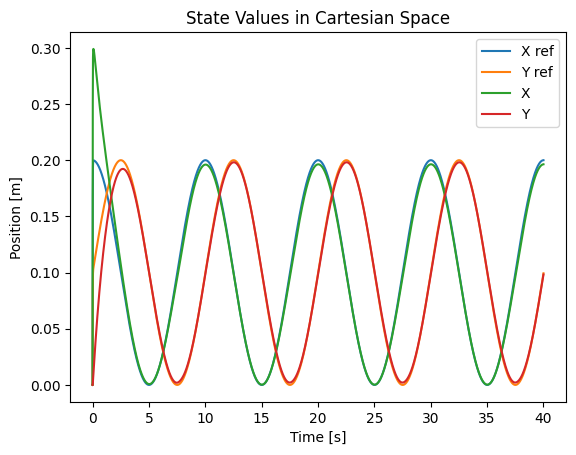

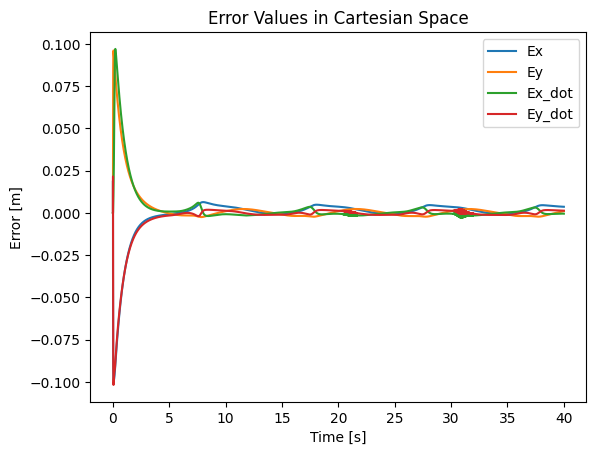

In [24]:

ks = 240.43019522362528
lam = 1.1027054080379453
model, state_probe, reference_probe = create_model_no_adapt(ks,lam)
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()

print(np.sqrt(np.mean((ref_signal-state_signal)**2)))


plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

## Adaptive Random

In [5]:
#learning_rate = 8.96982048041734e-07
learning_rate =  0.0003213804133180894
ks =  208.55172169442326
lam = 0.9629358868431545
#ks = 240.43019522362528
#lam = 1.1027054080379453
dist = 0
model, state_probe, reference_probe = create_model_rand_adapt_2(ks,lam,learning_rate)
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()

print(np.sqrt(np.mean((ref_signal-state_signal)**2)))

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])






NameError: name 'arm' is not defined

## Selected Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.011549646411303927


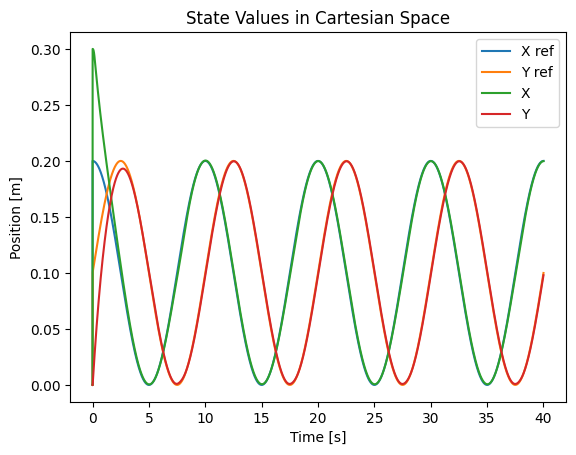

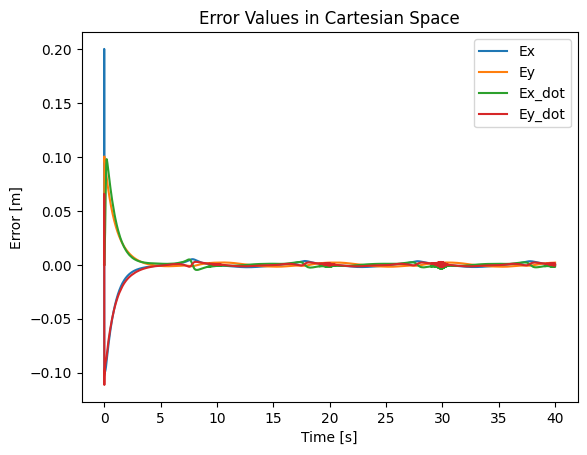

In [38]:

#learning_rate = 8.96982048041734e-07
learning_rate =  7.689009497002316e-06
ks =  205.9303875350412
lam = 1.057290908922065
rho_specified = 0.9456234514109944
gain = 179.44234436773934
#ks = 240.43019522362528
#lam = 1.1027054080379453
model, state_probe, reference_probe = create_model_proj_adapt_2(ks,lam,learning_rate,rho_specified,gain)
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()
print(np.sqrt(np.mean((ref_signal-state_signal)**2)))

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])






## SSP Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.011583596569709675


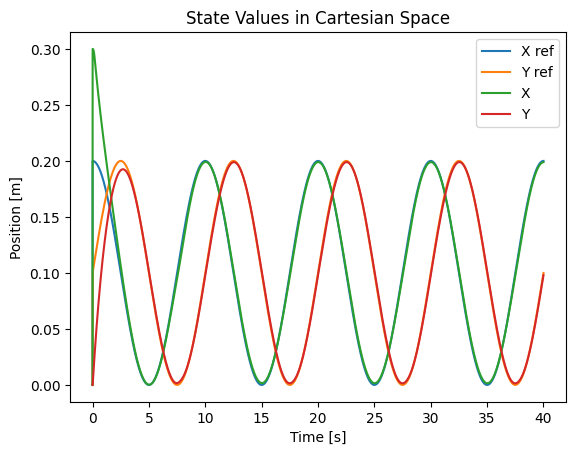

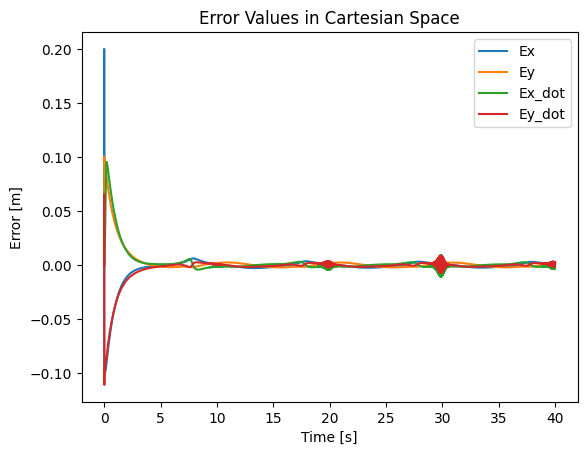

In [43]:
encoders_type = 'place-cells'
psd_sampling = 'gaussian'
domain_ranges_ = np.array([[-0.3,0.3],[-1.,1.],[-0.3,0.3],[-1.,1.]])
ssp_dim = 512
length_scale = np.asarray([[0.82,5.31,0.5,5]])

#learning_rate = 8.96982048041734e-07
learning_rate =  7.689009497002316e-06
ks =  205.9303875350412
lam = 1.057290908922065
rho_specified = 0.9456234514109944
gain = 179.44234436773934
#ks = 240.43019522362528
#lam = 1.1027054080379453

#model, state_probe, reference_probe = create_model_SSP_adapt_2(ks,lam,learning_rate,rho_specified,gain)
ks= 204.45600200864544
lam =1.0559508398498167
learning_rate = 9.43515812051786e-06
model, state_probe, reference_probe = create_model_SSP_adapt_3(ks,lam,learning_rate)


with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()

print(np.sqrt(np.mean((ref_signal-state_signal)**2)))
plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])






# With Disturbances

In [49]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        p0 = np.array([0,0])
        p1 = p0 + np.array([self.l0*np.cos(inputs[0]),self.l0*np.sin(inputs[0])])
        p2 = p1 + np.array([self.l1*np.cos(inputs[0]+inputs[1]),self.l1*np.sin(inputs[0]+inputs[1])])
        p3 = p2 + np.array([self.l2*np.cos(inputs[0]+inputs[1]+inputs[2]),self.l2*np.sin(inputs[0]+inputs[1]+inputs[2])])
        if(dist == 1 and t >= dist_time):
            #m_dist = 2
            #dist_in = 1000*np.matrix([np.cos(p3[0]),np.sin(p3[1]),0])
            dist_in = np.matrix([0,-50,0])
        else:
            #m_dist = 0
            dist_in = np.matrix([0,0,0])
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);
    
        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        #Fqg3 = JofXwrtQ3.T * Fg * (self.m2+m_dist);
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T+np.transpose(np.matmul(dist_in,JofXwrtQ3))
        
        #Get accerlation and velocity
        # Need joint limit check 
        #theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2+m_dist)
        #theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2+m_dist)
        #theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2+m_dist)
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J




## No Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.053617242178624125
Proportional RMSE
0.020119312319460722


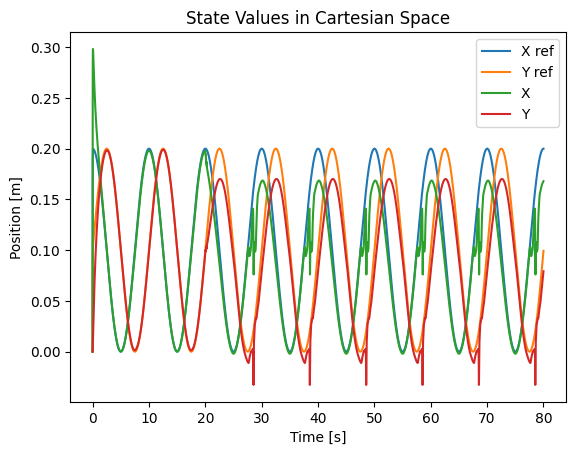

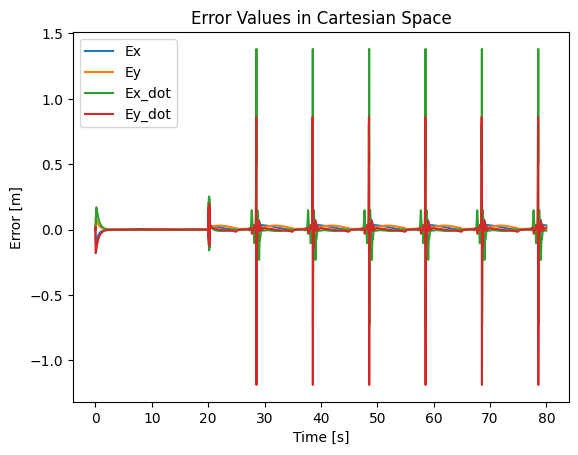

In [54]:
sim_time = 80
dist = 1
dist_time = 20
#ks = 240.43019522362528
#lam = 1.1027054080379453
ks = 237.82543294678618
lam = 1.9956446672813293
model, state_probe, reference_probe = create_model_no_adapt(ks,lam)
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()

print(np.sqrt(np.mean((ref_signal-state_signal)**2)))
print("Proportional RMSE")
print(np.sqrt(np.mean((ref_signal[:,0:2]-state_signal[:,0:2])**2)))

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

In [217]:
print(np.sqrt(np.mean((ref_signal[:,0:2]-state_signal[:,0:2])**2)))



0.020119312319460722


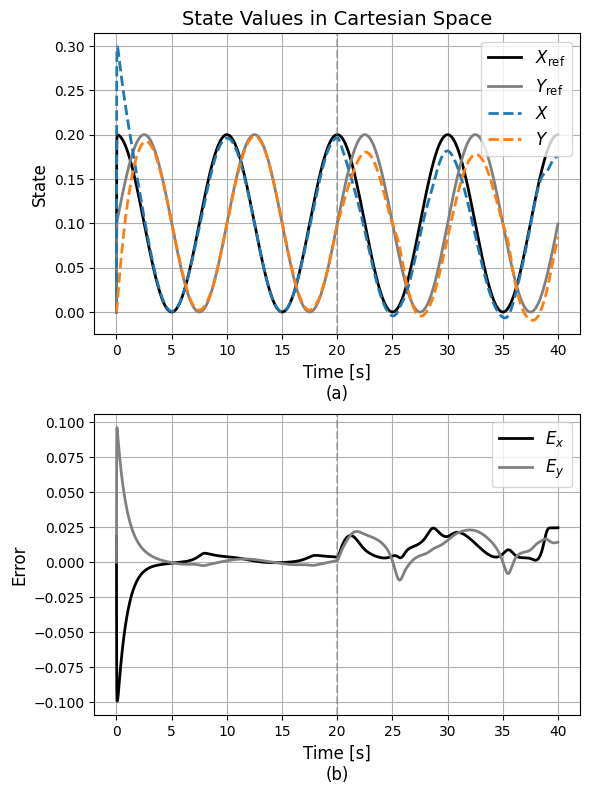

In [110]:
# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# First subplot: State Values in Cartesian Space
ax1.plot(t, ref_signal[:, 0], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax1.plot(t, ref_signal[:, 1], linestyle='-', color='gray', label=r'$Y_{\text{ref}}$', linewidth=2)
ax1.plot(t, state_signal[:, 0], linestyle='--', color='#1f77b4', label='$X$', linewidth=2)
ax1.plot(t, state_signal[:, 1], linestyle='--', color='#ff7f0e', label='$Y$', linewidth=2)
ax1.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('State', fontsize=12)
ax1.set_title("State Values in Cartesian Space", fontsize=14)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True)
ax1.text(0.5, -0.2, '(a)', transform=ax1.transAxes, fontsize=12, va='center', ha='center')

# Second subplot: Error Values in Cartesian Space
ax2.plot(t, error_sig[:, 0], linestyle='-', color='black', label='$E_x$', linewidth=2)
ax2.plot(t, error_sig[:, 1], linestyle='-', color='gray', label='$E_y$', linewidth=2)
#ax2.plot(t, error_sig[:, 2], linestyle='--', color='#1f77b4', label=r'$E_{\dot{x}}$', linewidth=2)
#ax2.plot(t, error_sig[:, 3], linestyle='--', color='#ff7f0e', label=r'$E_{\dot{y}}$', linewidth=2)
ax2.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
#ax2.set_title("Error Values in Cartesian Space", fontsize=14)
ax2.legend(loc='best', fontsize=12)
ax2.grid(True)
ax2.text(0.5, -0.2, '(b)', transform=ax2.transAxes, fontsize=12, va='center', ha='center')

# Adjust layout for better spacing and save the figure
plt.tight_layout()
plt.savefig('Adaptive_None_Result.png', dpi=300, bbox_inches='tight')
plt.show()


## Random Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

3.9038933193253e+74
Proportional RMSE
0.125471106721582


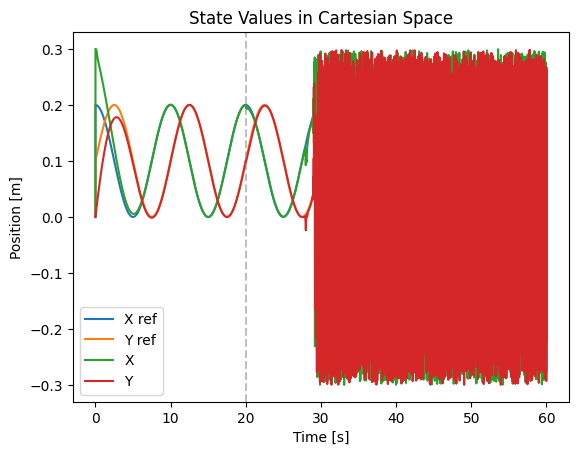

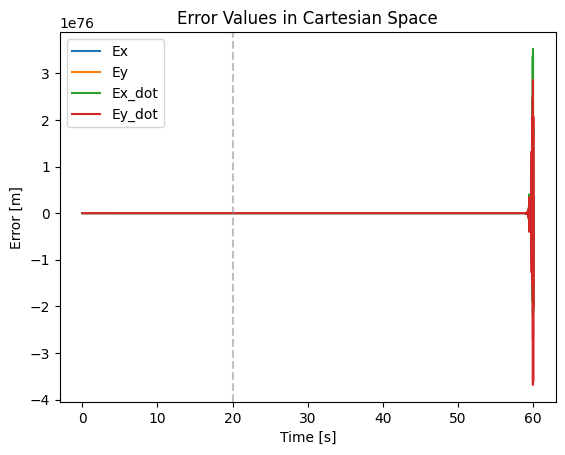

In [53]:
dist = 1
dist_time = 20
#learning_rate =  0.0003213804133180894
#ks =  208.55172169442326
#lam = 0.9629358868431545
#ks = 174.5060858329416
#lam = 1.9491935150052653
#learning_rate = 0.0008456897193426827

ks = 172.92698399221555
lam = 0.5706395245491774
learning_rate = 0.0008935049630213426

model, state_probe, reference_probe = create_model_rand_adapt_2(ks,lam,learning_rate)
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()

print(np.sqrt(np.mean((ref_signal-state_signal)**2)))
print("Proportional RMSE")
print(np.sqrt(np.mean((ref_signal[:,0:2]-state_signal[:,0:2])**2)))

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)  

plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)  

plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])






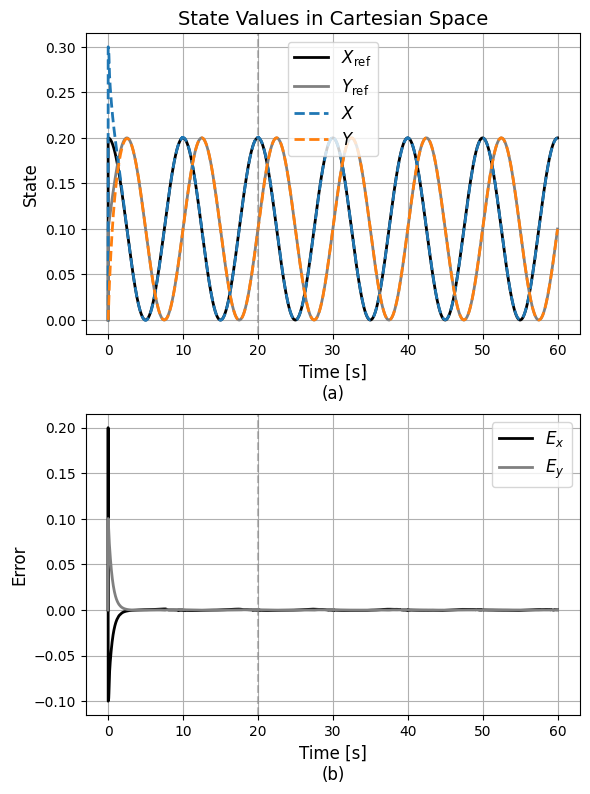

In [43]:
# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# First subplot: State Values in Cartesian Space
ax1.plot(t, ref_signal[:, 0], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax1.plot(t, ref_signal[:, 1], linestyle='-', color='gray', label=r'$Y_{\text{ref}}$', linewidth=2)
ax1.plot(t, state_signal[:, 0], linestyle='--', color='#1f77b4', label='$X$', linewidth=2)
ax1.plot(t, state_signal[:, 1], linestyle='--', color='#ff7f0e', label='$Y$', linewidth=2)
ax1.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('State', fontsize=12)
ax1.set_title("State Values in Cartesian Space", fontsize=14)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True)
ax1.text(0.5, -0.2, '(a)', transform=ax1.transAxes, fontsize=12, va='center', ha='center')

# Second subplot: Error Values in Cartesian Space
ax2.plot(t, error_sig[:, 0], linestyle='-', color='black', label='$E_x$', linewidth=2)
ax2.plot(t, error_sig[:, 1], linestyle='-', color='gray', label='$E_y$', linewidth=2)
#ax2.plot(t, error_sig[:, 2], linestyle='--', color='#1f77b4', label=r'$E_{\dot{x}}$', linewidth=2)
#ax2.plot(t, error_sig[:, 3], linestyle='--', color='#ff7f0e', label=r'$E_{\dot{y}}$', linewidth=2)
ax2.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
#ax2.set_title("Error Values in Cartesian Space", fontsize=14)
ax2.legend(loc='best', fontsize=12)
ax2.grid(True)
ax2.text(0.5, -0.2, '(b)', transform=ax2.transAxes, fontsize=12, va='center', ha='center')

# Adjust layout for better spacing and save the figure
plt.tight_layout()
plt.savefig('Adaptive_Random_Result.png', dpi=300, bbox_inches='tight')
plt.show()


## Selected Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.028120507643056573
Proportional RMSE
0.009997803047788969


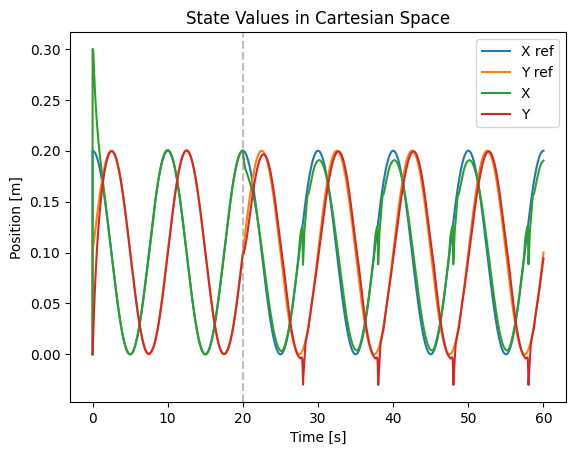

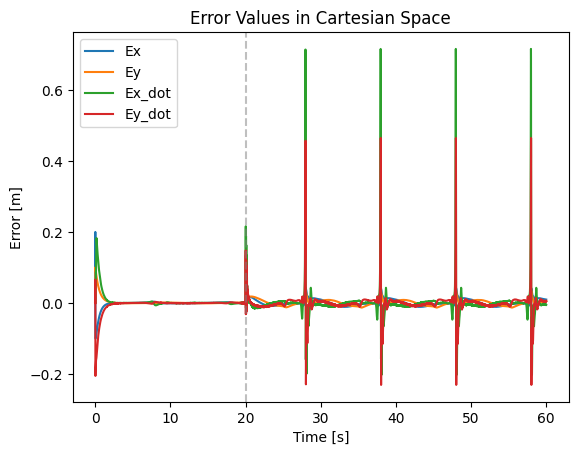

In [51]:
dist = 1
dist_time = 20
'''
learning_rate =  7.689009497002316e-06
ks =  205.9303875350412
lam = 1.057290908922065
rho_specified = 0.9456234514109944
gain = 179.44234436773934

ks = 201.7113949487002
lam = 1.999789138629936
learning_rate = 9.684232581304624e-06
rho_specified = 0.6681409121888298
gain = 241.1638796057436
'''

ks=196.11618763796173
lam=1.997902049591582
learning_rate=9.963797644587236e-06
rho_specified=0.5904934874971519
gain=225.43220259102085
model, state_probe, reference_probe = create_model_proj_adapt_2(ks,lam,learning_rate,rho_specified,gain)
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()
print(np.sqrt(np.mean((ref_signal-state_signal)**2)))
print("Proportional RMSE")
print(np.sqrt(np.mean((ref_signal[:,0:2]-state_signal[:,0:2])**2)))

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)  
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)  
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])






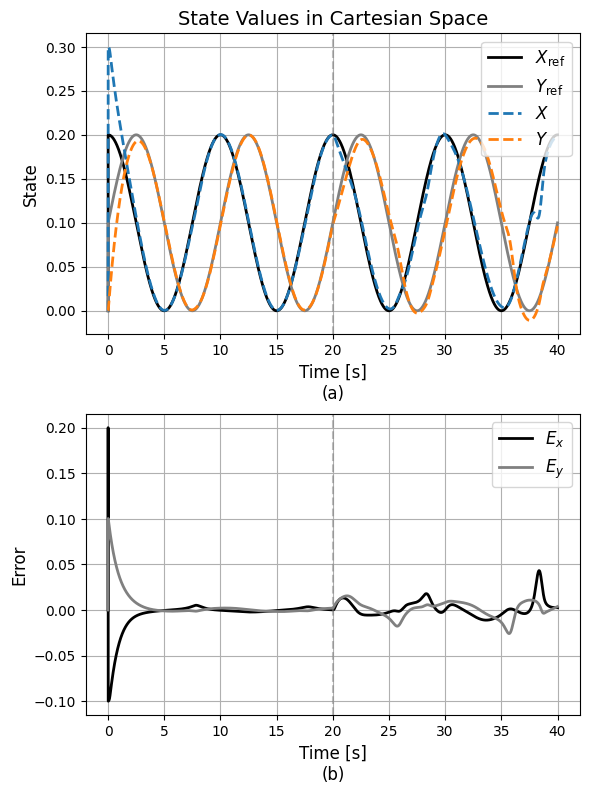

In [106]:
# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# First subplot: State Values in Cartesian Space
ax1.plot(t, ref_signal[:, 0], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax1.plot(t, ref_signal[:, 1], linestyle='-', color='gray', label=r'$Y_{\text{ref}}$', linewidth=2)
ax1.plot(t, state_signal[:, 0], linestyle='--', color='#1f77b4', label='$X$', linewidth=2)
ax1.plot(t, state_signal[:, 1], linestyle='--', color='#ff7f0e', label='$Y$', linewidth=2)
ax1.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('State', fontsize=12)
ax1.set_title("State Values in Cartesian Space", fontsize=14)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True)
ax1.text(0.5, -0.2, '(a)', transform=ax1.transAxes, fontsize=12, va='center', ha='center')

# Second subplot: Error Values in Cartesian Space
ax2.plot(t, error_sig[:, 0], linestyle='-', color='black', label='$E_x$', linewidth=2)
ax2.plot(t, error_sig[:, 1], linestyle='-', color='gray', label='$E_y$', linewidth=2)
#ax2.plot(t, error_sig[:, 2], linestyle='--', color='#1f77b4', label=r'$E_{\dot{x}}$', linewidth=2)
#ax2.plot(t, error_sig[:, 3], linestyle='--', color='#ff7f0e', label=r'$E_{\dot{y}}$', linewidth=2)
ax2.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
#ax2.set_title("Error Values in Cartesian Space", fontsize=14)
ax2.legend(loc='best', fontsize=12)
ax2.grid(True)
ax2.text(0.5, -0.2, '(b)', transform=ax2.transAxes, fontsize=12, va='center', ha='center')

# Adjust layout for better spacing and save the figure
plt.tight_layout()
plt.savefig('Adaptive_Selected_Result.png', dpi=300, bbox_inches='tight')
plt.show()


## SSP Adaptive

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.028675932051954737
Proportional RMSE
0.010843957140291806


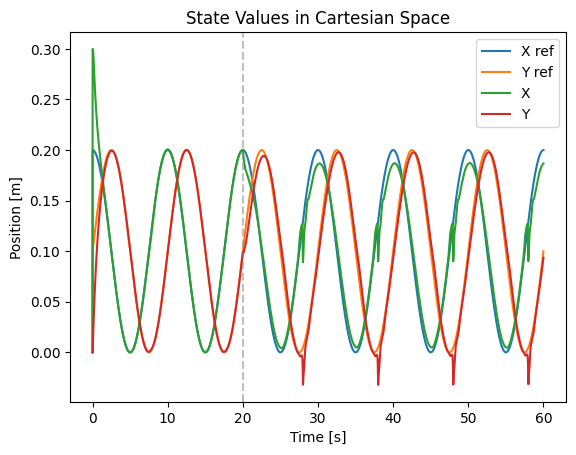

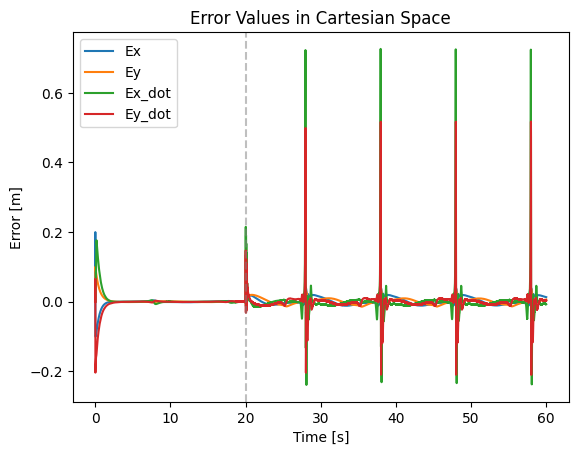

In [52]:
dist = 1
dist_time = 20


encoders_type = 'place-cells'
#encoders_type = 'random'
psd_sampling = 'gaussian'
domain_ranges_ = np.array([[-0.3,0.3],[-1.,1.],[-0.3,0.3],[-1.,1.]])
ssp_dim = 512
length_scale = np.asarray([[0.82,5.31,0.5,5]])

#model, state_probe, reference_probe = create_model_SSP_adapt_2(ks,lam,learning_rate,rho_specified,gain)
#ks= 204.45600200864544
#lam =1.0559508398498167
#learning_rate = 9.43515812051786e-06
#ks = 197.72100641535516
#lam = 1.9966037360963915
#learning_rate = 8.908973916524767e-06
ks=  197.20659468929298
lam = 1.9752868064881248
learning_rate = 9.762855388852604e-06


model, state_probe, reference_probe = create_model_SSP_adapt_3(ks,lam,learning_rate)


with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)
ref_signal = sim.data[reference_probe]
state_signal = -sim.data[state_probe]
error_sig = ref_signal-state_signal
t = sim.trange()

print(np.sqrt(np.mean((ref_signal-state_signal)**2)))
print("Proportional RMSE")
print(np.sqrt(np.mean((ref_signal[:,0:2]-state_signal[:,0:2])**2)))

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)  
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_sig)
plt.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)  
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])






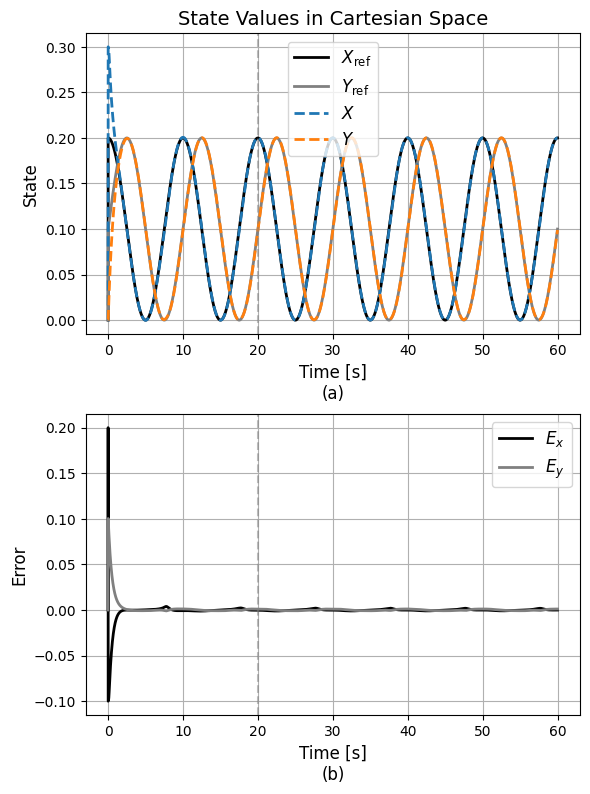

In [45]:
# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# First subplot: State Values in Cartesian Space
ax1.plot(t, ref_signal[:, 0], linestyle='-', color='black', label=r'$X_{\text{ref}}$', linewidth=2)
ax1.plot(t, ref_signal[:, 1], linestyle='-', color='gray', label=r'$Y_{\text{ref}}$', linewidth=2)
ax1.plot(t, state_signal[:, 0], linestyle='--', color='#1f77b4', label='$X$', linewidth=2)
ax1.plot(t, state_signal[:, 1], linestyle='--', color='#ff7f0e', label='$Y$', linewidth=2)
ax1.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time [s]', fontsize=12)
ax1.set_ylabel('State', fontsize=12)
ax1.set_title("State Values in Cartesian Space", fontsize=14)
ax1.legend(loc='best', fontsize=12)
ax1.grid(True)
ax1.text(0.5, -0.2, '(a)', transform=ax1.transAxes, fontsize=12, va='center', ha='center')

# Second subplot: Error Values in Cartesian Space
ax2.plot(t, error_sig[:, 0], linestyle='-', color='black', label='$E_x$', linewidth=2)
ax2.plot(t, error_sig[:, 1], linestyle='-', color='gray', label='$E_y$', linewidth=2)
#ax2.plot(t, error_sig[:, 2], linestyle='--', color='#1f77b4', label=r'$E_{\dot{x}}$', linewidth=2)
#ax2.plot(t, error_sig[:, 3], linestyle='--', color='#ff7f0e', label=r'$E_{\dot{y}}$', linewidth=2)
ax2.axvline(x=dist_time, color='grey', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
#ax2.set_title("Error Values in Cartesian Space", fontsize=14)
ax2.legend(loc='best', fontsize=12)
ax2.grid(True)
ax2.text(0.5, -0.2, '(b)', transform=ax2.transAxes, fontsize=12, va='center', ha='center')

# Adjust layout for better spacing and save the figure
plt.tight_layout()
plt.savefig('Adaptive_SSP_Result.png', dpi=300, bbox_inches='tight')
plt.show()
